In [1]:
import pandas as pd
import os
import json
from nltk.tokenize import sent_tokenize
import json
import copy
from collections import defaultdict

import pandas as pd

def identify_and_merge_major_category(entity_counts):
    for entity, counts in entity_counts.items():
        # if entity == 'calcified nodule':
        #     print("before entity_counts", entity_counts[entity])
        if len(counts.keys())> 1:
            total_count = sum(counts.values())  # 총 카운트 계산
            major_category, major_count = max(counts.items(), key=lambda x: x[1])  # 가장 많은 카운트와 카테고리 찾기 
            # print("major_category, major_count, total_count", major_category, major_count, total_count)
            
            if major_count / total_count >= 0.5:  # 만약 major 카테고리가 전체의 90% 이상을 차지한다면
                entity_counts[entity] = {major_category: total_count}  # 나머지 카테고리를 major 카테고리로 변경
                # print("after entity_counts", entity_counts[entity])
        else:
            pass
    return entity_counts


def compute_jaccard_similarity_word_based(str1, str2):
    """Compute the Jaccard Similarity score between two strings on word basis."""
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0


extract_dir = '/home/edlab/jhmoon/SUB_OBJ_vocab/NER/output/gpt4_v3/'
extracted_files = os.listdir(extract_dir)

patients = os.path.join(extract_dir, extracted_files[0])
studies = os.listdir(patients)

print(extracted_files)
print(len(extracted_files))

['p10032725', 'p10046166', 'p10183775', 'p10268877', 'p10274145', 'p10305005', 'p10402372', 'p10410641', 'p10439781', 'p10449297', 'p10523725', 'p10532326', 'p10650001', 'p10715477', 'p10754184', 'p10850815', 'p10867202', 'p10885696', 'p10886362', 'p10933609', 'p10959054', 'p10975446', 'p11016935', 'p11022245', 'p11052273', 'p11052935', 'p11204646', 'p11212873', 'p11213613', 'p11293517', 'p11378150', 'p11413236', 'p11474065', 'p11512104', 'p11540283', 'p11565803', 'p11569042', 'p11569093', 'p11607628', 'p11673948', 'p11879886', 'p11880923', 'p11893091', 'p11906222', 'p11924226', 'p11928692', 'p11934114', 'p12074041', 'p12110863', 'p12124741', 'p12136799', 'p13762730', 'p15207316', 'p16848073', 'p18767957', 'p12145137', 'p13849733', 'p15259244', 'p12185775', 'p18828251', 'p13866940', 'p13881772', 'p16853729', 'p18835687', 'p18855147', 'p16855430', 'p13896515', 'p18874374', 'p12189285', 'p18893199', 'p12303667', 'p18906643', 'p15272972', 'p12340737', 'p15321868', 'p12369221', 'p12379369'

In [2]:
import re
# Define a mapping of column name variations to standard names
column_variations = {
    'emerge': ['emerg', 'emerge', 'emrg'],
    'no change': ['nchg', 'no change'],
    'distribution': ['dist', 'distribution', 'distribute'],
    'severity': ['sev', 'severity', 'seve'],
    'location': ['loc', 'location'],
    'evidence': ['evd', 'evidence'],
    'morphology': ['mor', 'morp', 'morph'],
    'improved': ['impr', 'improve', 'improved', 'imp', 'improv', 'improvement'],
    'reposition': ['repl', 'replace', 'repo', 'positioning'],
    'resolve': ['res', 'resolve', 'resolved', 'resolv', 'resv'],
    'comparision': ['com', 'comp', 'comparision', 'compare'],
    'past hx': ['hx', 'past hx', 'past history', 'surgery process', 'post hx'],
    'other source': ['other source', 'other', 'source'],
    'technical limitation': ['tech', 'technical limitation', 'technical', 'limitation'],
    'worsened': ['wors', 'worsened', 'worse']
}

sub_category_mapping = {
    'appr': ['morphology', 'distribution', 'size'],
    'level': ['num', 'severity', 'comparision'],
    'tmp': ['emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve']
}


group_by_columns = ['idx',  'ent', 'cat', 'report', 'status', 'sent']

# Determine columns to be aggregated
aggregate_columns = ['location', 'evidence', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation', 'misc']

reverse_variations = {variation: standard_name for standard_name, variations in column_variations.items() for variation in variations}

# Function to map variations to standard column names
def standardize_columns(df, variations_map):
    for standard_name, variations in variations_map.items():
        for variation in variations:
            if variation in df.columns:
                df.rename(columns={variation: standard_name}, inplace=True)
    return df

# def process_dict_values(row, dict_name):#, sentences, raw_sentences, df_sec, subject_id, std_id, std_sequence):
def process_dict_values(row, dict_name, df_sec, subject_id, std_id, std_sequence):
    processed_rows = []
    data_dict = row.get(dict_name, {})

    # 문장이 존재하는 경우, 해당 문장을 가져옴
    row_dict = row.to_dict()  # Series를 딕셔너리로 변환

    for key, compound_val in data_dict.items():
        new_row = row_dict.copy()  # 기존 row_dict의 복사본을 사용하여 수정 시작
        
        standard_key = reverse_variations.get(key, key)
        
        if key in sub_category_mapping:
            for sub_key in sub_category_mapping[key]:
                standard_sub_key = reverse_variations.get(sub_key, sub_key)
                new_row[standard_sub_key.lower()] = ''
        else:
            new_row[standard_key.lower()] = ''
        
        if compound_val:  # 값이 없는 경우, key만 처리하고 value는 빈 문자열로 처리
            # 값이 리스트인 경우, 콤마로 구분된 문자열로 변환
            if isinstance(compound_val, list):
                compound_val = ', '.join(compound_val)


            if isinstance(compound_val, str):
                # 'OTH' 필드 내의 특정 키 처리
                if dict_name == 'OTH':
                    # '|' 기준으로 분할된 값 처리
                    if '|' in compound_val:
                        parts = compound_val.split('|')
                        compound_val = parts[-1]  # 마지막 부분만 사용


                # 콤마로 구분된 값을 처리
                for val in compound_val.split(', '):
                    parts = val.split('|')
                    if len(parts) == 2:
                        # '|'로 구분된 값이 정확히 두 부분일 때 새로운 키와 값으로 분리
                        new_key, new_val = parts                        

                        if standard_key.lower() == 'evidence':
                            new_row[standard_key.lower()] = f'{new_key}, {new_val}'
                        
                        else:
                            standard_new_key = reverse_variations.get(new_key, new_key)
                            new_row[standard_new_key.lower()] = new_val.lower()
                    else:
                        # '|'가 없는 경우, 키에 해당하는 전체 값을 그대로 사용
                        new_row[standard_key.lower()] = val.lower()
                        
            elif isinstance(compound_val, dict):
                # 여기에서 compound_val이 딕셔너리일 때의 처리 로직을 추가합니다.
                # 예: new_row[standard_key.lower()] = str(compound_val)
                
                print("compound_val", compound_val)
                print(" subject_id, std_id, std_sequence",  subject_id, std_id, std_sequence)
                input("STOP!!O!!P!P!!!")
                pass
            
        processed_rows.append(new_row)

    return pd.DataFrame(processed_rows)

def clean_list(value_list):
    # Remove empty strings and strings consisting only of commas and/or spaces
    return [item for item in value_list if item.strip(',') and item.strip()]

def list_to_string(row):
    """DataFrame의 각 행에 대해, 모든 리스트 값을 문자열로 변환."""
    for column in row.index:
        if isinstance(row[column], list):
            row[column] = ', '.join(map(str, row[column]))  # 리스트를 문자열로 변환
    return row


def fix_quotes(json_str):
    # "sent": 직후의 첫 번째 작은따옴표를 큰따옴표로 변경
    fixed_str = re.sub(r'("sent":\s*)\'', r'\1"', json_str)
    
    # ", "ent": 직전의 마지막 작은따옴표를 큰따옴표로 변경
    fixed_str = re.sub(r'\',\s*("ent":)', r'", \1', fixed_str)
    
    fixed_str = fixed_str.strip()  # 양쪽 공백 제거
    
    if fixed_str.startswith(','):
        fixed_str = fixed_str[1:]  # 시작 부분의 불필요한 콤마 제거
    if fixed_str.endswith(','):
        fixed_str = fixed_str[:-1]  # 끝 부분의 불필요한 콤마 제거
    
    # 배열의 마지막 원소 뒤의 불필요한 콤마를 제거
    # 이는 배열이 닫히기 직전에 위치한 콤마에 대응됨.
    fixed_str = re.sub(r',\s*\]', ']', fixed_str)

    # 필요시 JSON 배열로 변환
    if not fixed_str.startswith('['):
        fixed_str = '[' + fixed_str
    if not fixed_str.endswith(']'):
        fixed_str += ']'

    return fixed_str


## GPT 4 결과 예외처리.

In [4]:
def display_data(data):
    sections = {
        "HIST": data.get("History", ""),
        "FIND": data.get("Findings", ""),
        "IMPR": data.get("Impression", "")
    }
    other_info = {
        "subject": data.get("subject", ""),
        "study": data.get("study", ""),
        "sequence": data.get("sequence", "")
    }
    
    dfs = pd.DataFrame(columns=['patient_id', 'study_id', 'sequence', 'sec', 'idx',  'report', 'sent', 'ent', 'cat', 'status', 'location', 'evidence', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation', 'misc'])

    annotations = data.get('annotations', [])    
    show_column = ['idx',  'report', 'sec', 'sent', 'ent', 'cat', 'status', 'location', 'evidence', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation', 'misc']

    for each_std in range(len(annotations)):
        for sec in sections.keys():
            fixed_json_str = fix_quotes(annotations[each_std])
            subject_id, std_id, std_sequence = other_info["subject"][each_std], other_info["study"][each_std], other_info["sequence"][each_std]

            try:
                parsed_json = json.loads(fixed_json_str)
            except json.JSONDecodeError as e:
                print("Failed to parse JSON:", fixed_json_str)
                
                print("subject_id, std_id, std_sequence", subject_id, std_id, std_sequence)
                error_message = str(e)
                print("Failed to parse JSON:", error_message)
                
                # 정규 표현식을 사용하여 'char' 다음에 오는 숫자를 추출합니다.
                match = re.search(r'char (\d+)', error_message)
                if match:
                    error_position = match.group(1)  # 매칭된 첫 번째 그룹 (숫자)을 추출합니다.
                    print("Error at position:", error_position)
                else:
                    print("Could not find the error position.")
                print("Failed to parse JSON:", fixed_json_str[int(error_position)-5:int(error_position)+5])
                
            filtered_annotations = [item for item in parsed_json if item['sec'] == sec]
            
            # 섹션을 문장으로 분리
            df_sec = pd.DataFrame(columns=show_column)

            if filtered_annotations:
                df_sec = pd.DataFrame(filtered_annotations)
                
                all_processed_rows = []
                for _, row in df_sec.iterrows():
                    # 'attr', 'rel', 'OTH' 각각 처리
                    for dict_name in ['attr', 'rel', 'OTH']:
                        # processed_df = process_dict_values(row, dict_name)#, sentences, raw_sentences, df_sec, subject_id, std_id, std_sequence)
                        processed_df = process_dict_values(row, dict_name, df_sec, subject_id, std_id, std_sequence)
                        all_processed_rows.append(processed_df)
                        
                if all_processed_rows:
                    df_sec = pd.concat(all_processed_rows, ignore_index=True)
                
                df_sec.drop(columns=['attr', 'rel', 'OTH', 'appr', 'tmp', 'level'], errors='ignore', inplace=True)
                    
                # Standardize column names based on variations
                df_sec = standardize_columns(df_sec, column_variations)

        
            extra_columns = set(df_sec.columns) - set(show_column)
            if extra_columns and not extra_columns.issubset({'report', 'sec'}):
                print("Failed to parse JSON:", fixed_json_str)
                print("subject_id, std_id, std_sequence", subject_id, std_id, std_sequence)
                
                raise ValueError(f"Extra columns found that are not defined in show_column: {extra_columns}")

            try:
                # 재색인 시도
                df_sec = df_sec.reindex(columns=show_column).fillna('')
            except ValueError as e:
                print("ValueError 발생:", e)
                
                # 중복된 열 이름이 원인인지 확인
                if 'duplicate labels' in str(e):
                    # 중복된 열 이름 식별
                    duplicates = df_sec.columns[df_sec.columns.duplicated()].tolist()
                    print("Failed to parse JSON:", fixed_json_str)
                    print("subject_id, std_id, std_sequence", subject_id, std_id, std_sequence)
                    print("중복된 열 이름:", duplicates)
                else:
                    # 다른 종류의 ValueError 처리
                    print("다른 유형의 ValueError입니다. 메시지:", e)
            except Exception as e:
                # 다른 모든 예외 처리
                print("예상치 못한 에러 발생:", e)

            # print("22 df_sec", df_sec['sent_idx'])
            
            #######################################################################################################################################################################################
            # Ensure each aggregate column is a list (this simplifies combining them later)
            for column in aggregate_columns:
                df_sec[column] = df_sec[column].apply(lambda x: [x] if pd.notnull(x) else [])

            # Group by the specified columns and aggregate the rest
            df_sec = df_sec.groupby(group_by_columns, as_index=False).agg({col: 'sum' for col in aggregate_columns})

            # Optionally, remove duplicates from each aggregated list
            for column in aggregate_columns:
                df_sec[column] = df_sec[column].apply(clean_list)
                # df_sec[column] = df_sec[column].apply(lambda x: list(set(x)))

            df_sec['sec'] = sec
            df_sec['report'] = sections[sec][each_std]
            # df_sec['raw_report'] = raw_report[sec][each_std]            
            df_sec['patient_id'] = subject_id
            df_sec['study_id'] = std_id
            df_sec['sequence'] = std_sequence

            df_sec = df_sec.sort_values(by='idx', ascending=True)            
            dfs = pd.concat([dfs, df_sec], ignore_index=True)

    return dfs


In [9]:
# from tqdm import tqdm
# def load_json_content(file_path):
#     with open(file_path, 'r') as file:
#         return json.load(file)

# df_final = pd.DataFrame(columns=['patient_id', 'study_id', 'sequence', 'sec', 'report', 'sent', 'ent', 'cat', 'status', 'location', 'evidence', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation', 'misc'])

# for patient_idx, patient_itr in tqdm(enumerate(extracted_files), total=len(extracted_files), desc="Loading Patients"):
    
#     patient_dir = os.path.join(extract_dir, patient_itr)
#     study_lists = os.listdir(patient_dir)

#     study_append_list = []
#     for std_idx, std_itr in enumerate(study_lists):
#         json_content = load_json_content(os.path.join(patient_dir, std_itr))
#         study_append_list.append(json_content)
    
#     patient_df = pd.DataFrame(study_append_list)
    
#     expanded_df = display_data(patient_df)
#     expanded_df = expanded_df.apply(list_to_string, axis=1)
#     df_final = pd.concat([df_final, expanded_df], ignore_index=True)


# df_final = pd.read_csv('./gpt4_result.csv')
# df_final.head()

df_final = pd.read_csv('./gpt4_result_radlex_norm.csv')
df_final.head()

,Unnamed: 0.1,Unnamed: 0,patient_id,study_id,sequence,sec,report,sent,ent,cat,...,radlex_resolve_code,radlex_past hx,radlex_past hx_path,radlex_past hx_code,radlex_other source,radlex_other source_path,radlex_other source_code,radlex_technical limitation,radlex_technical limitation_path,radlex_technical limitation_code
0,0,0,p10032725,s50331901,1,HIST,Intubated-year-old woman. Check tube placement.,Intubated-year-old woman. Check tube placement.,Intubated,OTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,p10032725,s50331901,1,IMPR,AP chest compared to : Tip of the endotracheal...,AP chest compared to : Tip of the endotracheal...,endotracheal tube,OTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,p10032725,s50331901,1,IMPR,AP chest compared to : Tip of the endotracheal...,Lungs are clear.,lungs,ROF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,p10032725,s50331901,1,IMPR,AP chest compared to : Tip of the endotracheal...,Cardiomediastinal and hilar silhouettes and pl...,cardiomediastinal silhouettes,ROF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,p10032725,s50331901,1,IMPR,AP chest compared to : Tip of the endotracheal...,Cardiomediastinal and hilar silhouettes and pl...,hilar silhouettes,ROF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_final['cat'].value_counts()

cat
ROF    24828
OTH     7966
SYM     2494
RSF     2454
COF      747
OBS      286
Name: count, dtype: int64

In [11]:
display(df_final[['ent', 'location', 'radlex_location', 'morphology', 'radlex_morphology', 'past hx', 'radlex_past hx', 'technical limitation', 'radlex_technical limitation']].head(100))

# df_final.columns

,ent,location,radlex_location,morphology,radlex_morphology,past hx,radlex_past hx,technical limitation,radlex_technical limitation
0,Intubated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,endotracheal tube,upper margin of the clavicles,"margin, upper, clavicle",NaN,NaN,NaN,NaN,NaN,NaN
2,lungs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cardiomediastinal silhouettes,NaN,NaN,normal,normal,NaN,NaN,NaN,NaN
4,hilar silhouettes,NaN,NaN,normal,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,cardiac silhouette,NaN,NaN,NaN,NaN,NaN,NaN,could be accentuated by positioning and relati...,NaN
96,calcifications,aortic arch,aortic arch,NaN,NaN,NaN,NaN,NaN,NaN
97,degenerative changes,glenohumeral joints bilaterally,glenohumeral joint,NaN,NaN,NaN,NaN,NaN,NaN
98,osseous and soft tissue structures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from collections import defaultdict
import copy
# df_final = pd.read_csv('./gpt4_result_radlex_norm.csv')
# df_final = df_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis =1)#.columns
rest_cat_normalize = {'PEA arrest': 'OTH',
 'congestive heart failure': 'RSF',
 'CHF': 'RSF',
 'bacteremia': 'COF',
 'COPD': 'RSF',
 'volume overload': 'ROF',
 'CHF exacerbation': 'RSF',
 'aspiration event': 'COF',
 'inflammation': 'RSF',
 'sarcoidosis': 'RSF',
 'sarcoid': 'RSF',
 'cirrhosis': 'RSF',
 'congestive cardiac failure': 'RSF',
 'chronic heart failure': 'RSF',
 'hypoxic respiratory failure': 'COF',
 'chf': 'RSF',
 'asthma': 'SYM',
 'esophageal cancer': 'RSF',
 'MRSA bacteremia': 'COF',
 'small cell lung cancer': 'RSF',
 'pancreatitis': 'RSF'}


remove_list = ['Wet read', 'finding', 'old films', 'As above', 'initial report', 'Otherwise']

# 'ent' 컬럼 값이 remove_list에 정확히 일치하지 않는 행만 선택
dr_condition = df_final['ent'].str.contains('Dr.', na=False)
remove_list_condition = df_final['ent'].isin(remove_list)

# 두 조건 중 하나라도 True인 행을 제외
maunal_normalized_df = df_final[~(dr_condition | remove_list_condition)]

for index, row in maunal_normalized_df.iterrows():
    # entity를 문자열로 강제 변환
    entity = str(row['ent'])
    if 'fracture' in entity.lower():
        maunal_normalized_df.at[index, 'cat'] = 'ROF'
    elif entity in rest_cat_normalize:
        maunal_normalized_df.at[index, 'cat'] = rest_cat_normalize[entity]
        
entity_status_counts = defaultdict(lambda: defaultdict(int))
for _, row in maunal_normalized_df.iterrows():
    entity = row['ent']
    cat = row['cat']
    if pd.isna(cat):  # Skip rows where 'cat' might be NaN
        continue
    entity_status_counts[entity][cat] += 1


# 사용자 정의 함수 정의
def map_abbreviations(text):
    # text가 문자열이 아니면, 빈 문자열로 처리
    if not isinstance(text, str):
        # print("text!!", text)
        # input("ST!")
        return ""

    text = re.sub(r'\bdob off\b', 'Dobhoff', text, flags=re.IGNORECASE)

    text = re.sub(r'\bCABG\b', 'coronary artery bypass surgery', text, flags=re.IGNORECASE)
    text = re.sub(r'\bCOPD\b', 'chronic obstructive airway disease', text, flags=re.IGNORECASE)
    text = re.sub(r'\bchf\b', 'congestive heart failure', text, flags=re.IGNORECASE)
    text = re.sub(r'\bCP\b', 'costophrenic', text, flags=re.IGNORECASE)
    text = re.sub(r'\bcardiomediastinal silhouettes\b', 'cardiac shadow viewed radiologically', text, flags=re.IGNORECASE)
    text = re.sub(r'\bvomiting\b', 'vomit', text, flags=re.IGNORECASE)
    text = re.sub(r'\bcough\b', 'coughing', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpna\b', 'pneumonia', text, flags=re.IGNORECASE)
    text = re.sub(r'\bchill\b', 'chills', text, flags=re.IGNORECASE)
    text = re.sub(r'\bscarring\b', 'scar', text, flags=re.IGNORECASE)

    text = re.sub(r'\bDobbhoff\b', 'Dobhoff', text, flags=re.IGNORECASE)

    text = re.sub(r'\bGI\b', 'gastrointestinal', text, flags=re.IGNORECASE)
    # 대소문자 구분 없이 'et' 또는 'ET'을 'Endotracheal tube'로 교체
    text = re.sub(r'\bPICC\b', 'peripherally inserted central catheter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bet\b', 'endotracheal', text, flags=re.IGNORECASE)
    text = re.sub(r'\bij\b', 'internal jugular', text, flags=re.IGNORECASE)
    text = re.sub(r'\bbka\b', 'below-knee amputation', text, flags=re.IGNORECASE)
    # 대소문자 구분 없이 'ng' 또는 'NG'를 'nasogastric tube'로 교체
    text = re.sub(r'\bng\b', 'nasogastric', text, flags=re.IGNORECASE)
    return text


# 'ent' 컬럼에 대해 사용자 정의 함수 적용
maunal_normalized_df['ent'] = maunal_normalized_df['ent'].apply(map_abbreviations)

# Convert defaultdict to a regular dict for easier viewing
entity_status_counts_dict = {entity: dict(cat) for entity, cat in entity_status_counts.items()}

entity_status_counts_dict_original = copy.deepcopy(entity_status_counts_dict)
entity_counts_updated = identify_and_merge_major_category(entity_status_counts_dict)

before_entity_status_counts = {entity: cat for entity, cat in entity_status_counts_dict_original.items() if len(cat) > 1}
normed_entity_status_counts = {entity: cat for entity, cat in entity_counts_updated.items() if len(cat) > 1}

# 결과 출력
print(f"Before normlaize the categories: {len(before_entity_status_counts)} ent over 1 category")
print(f"After normlaize the categories: {len(normed_entity_status_counts)} ent over 1 category")
# entity_counts_updated#['ent']['lung']



Before normlaize the categories: 388 ent over 1 category
After normlaize the categories: 0 ent over 1 category


/tmp/ipykernel_3582577/3947120676.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maunal_normalized_df['ent'] = maunal_normalized_df['ent'].apply(map_abbreviations)


In [26]:
def select_ontology_norm(row):
    norms = [row['0_spacy_norm'], row['1_spacy_norm'], row['radlex_ent']]
    norms = [norm for norm in norms if pd.notnull(norm)]  # NaN 값 제거

    if len(norms) == 0:
        return None  # 모든 norm이 NaN인 경우, None 반환
    elif len(norms) == 1:
        return norms[0]  # 하나만 존재할 경우 그 값을 반환

    # Majority voting: 두 개 이상 같은 값이 있는지 확인
    if norms.count(norms[0]) > 1:
        return norms[0]
    elif len(norms) > 2 and norms.count(norms[1]) > 1:
        return norms[1]
    elif len(norms) > 2 and norms.count(norms[2]) > 1:
        return norms[2]

    # 유사도 계산
    ent = row['ent']
    best_norm_by_fuzz = norms[0]
    best_fuzz_score = fuzz.ratio(ent, best_norm_by_fuzz)

    for norm in norms[1:]:
        fuzz_score = fuzz.ratio(ent, norm)
        
        if fuzz_score > best_fuzz_score:
            best_fuzz_score = fuzz_score
            best_norm_by_fuzz = norm

    return best_norm_by_fuzz  # 가장 높은 fuzz 점수를 가진 norm 반환

# 동일한 'entity'에 대해 'ontology_norm'의 None이 아닌 첫 번째 값을 찾아서 해당 값으로 업데이트
def normalize_and_report_multiple_columns(df, columns):
    df_updated = df.copy()  # 원본 데이터 보존

    # 모든 주어진 열에 대해 처리
    for col in columns:
        # 각 열에 대해 dropna 및 groupby를 사용하여 첫 번째 값 추출
        grouped = df.dropna(subset=[col]).groupby('ent')[col]
        unique_values_per_ent = grouped.unique()

        # 유일한 값들의 수가 1인 'ent' 필터링
        valid_entities = unique_values_per_ent[unique_values_per_ent.apply(len) == 1]
        
        # 유일한 값들의 수가 1을 초과하는 'ent' 필터링 및 출력
        problematic_entities = unique_values_per_ent[unique_values_per_ent.apply(len) > 1]

        if col in ['radlex_ent', 'radlex_ent_code']:
            value_mapping = df.dropna(subset=[col]).groupby('ent')[col].first()
                
        elif not problematic_entities.empty:
            print(f"Entities with multiple unique '{col}' values:")
            display(problematic_entities)
            display(df[['radlex_ent', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls', '0_spacy_norm', '1_spacy_norm']])
            input("ST")

        # 정상적인 경우에만 매핑을 수행
        value_mapping = valid_entities.apply(lambda x: x[0])
        
        # 업데이트된 매핑을 적용
        df_updated[col] = df['ent'].map(value_mapping).fillna(df[col])

    return df_updated

In [13]:
df_final_filtered = pd.read_csv('./df_final_filtered.csv')

# print("len(df_final_filtered)", len(df_final_filtered))
df_final_filtered.dropna(subset=['ent'], inplace=True)

# print("len(df_final_filtered)", len(df_final_filtered))

df_final_filtered = df_final_filtered.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis =1)#.columns
df_final_filtered = df_final_filtered.merge(maunal_normalized_df, on =['patient_id', 'study_id', 'sequence', 'sec', 'report', 'sent', 'ent',
       'cat', 'status', 'location', 'evidence', 'morphology', 'distribution',
       'size', 'num', 'severity', 'comparision', 'emerge', 'no change',
       'improved', 'worsened', 'reposition', 'resolve', 'past hx',
       'other source', 'technical limitation', 'misc', 'idx'])

# print("len(df_final_filtered)", len(df_final_filtered))
for index, row in df_final_filtered.iterrows():
    # entity를 문자열로 강제 변환
    entity = str(row['ent'])
    if 'fracture' in entity.lower():
        df_final_filtered.at[index, 'cat'] = 'ROF'

df_final_filtered[['status_prefix', 'status_suffix']] = df_final_filtered['status'].str.split('|', expand=True)
df_final_filtered['cat'] = df_final_filtered['cat'].replace('OBS', 'ROF')


# 원본 DataFrame에 함수 적용
df_final_filtered = normalize_and_report_multiple_columns(df_final_filtered, ['radlex_ent', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls', '0_spacy_norm', '1_spacy_norm'])



df_final_filtered['ontology_norm'] = df_final_filtered.apply(select_ontology_norm, axis=1)


# 추가로, normalize 잘 안된 케이스들에 대해 manually update.
search_dict = {
    "volume": "Volume",
    "silhouette": "Silhouette sign",
    "collapse": "Collapsed Lung",
    "pulmonary lung metastases": "Pulmonary Metastasectomy",
    "aortic arch calcifications": "Aortic arch calcification",
    "aortic calcifications": "Aortic arch calcification",
    "edem": "Edema",
    "consol": "Lung consolidation",
    "densit": "density",
    "opacit": "Decreased translucency",
    "opacifi": "Opacification",
    "atel": "Atelectasis",
    "apical pneumothoraces": "Pneumothorax",
    "sterno": "Sternotomy (procedure)",
    "infla":"Lung hyperinflation",
    "atelectatic opacity": "Decreased translucency",
    "multifocal pneumonia": "Pneumonia"
}
for key, value in search_dict.items():
    # 조건에 맞는 행 찾기
    # df_final_filtered에서 'ent' 컬럼에 key(검색 조건)가 포함된 행을 찾습니다.
    mask = df_final_filtered['ent'].str.contains(key, na=False)
        
    # print(f"{value}==> {df_final_filtered[df_final_filtered['0_spacy_norm'] == value]['0_spacy_umls'].iloc[0]}")
    # 해당하는 행의 spacy_norm 컬럼을 value로 업데이트
    df_final_filtered.loc[mask, 'spacy_norm'] = value
    df_final_filtered.loc[mask, 'ontology_norm'] = value
    try:
        # 시도: '0_spacy_norm'에 해당하는 'spacy_umls' 값을 찾아 업데이트
        umls_value = df_final_filtered[df_final_filtered['0_spacy_norm'] == value]['0_spacy_umls'].iloc[0]
        df_final_filtered.loc[mask, 'spacy_umls'] = umls_value
    except IndexError:
        # 실패한 경우: '1_spacy_norm'에 해당하는 'spacy_umls' 값을 찾아 업데이트
        umls_value = df_final_filtered[df_final_filtered['1_spacy_norm'] == value]['1_spacy_umls'].iloc[0]
        df_final_filtered.loc[mask, 'spacy_umls'] = umls_value


# print(len(df_final_filtered[df_final_filtered['spacy_norm'].isna()]['ent']))
# print(len(df_final_filtered[df_final_filtered['spacy_umls'].isna()]['ent']))


normalize_fail = len(df_final_filtered[df_final_filtered['ontology_norm'].isna()]['ent'])
normalize_sucess = len(df_final_filtered[~df_final_filtered['ontology_norm'].isna()]['ent'])


sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_20_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient < 11)].index

# Step 1: Count 'TN' and 'TP' mentions for each patient
_2to_10_sequences_df = df_final_filtered[df_final_filtered['patient_id'].isin(patients_with_2_to_20_sequences)]


print(f"normalize_fail: {normalize_fail}, normalize_sucess: {normalize_sucess}")
display(df_final_filtered[df_final_filtered['ontology_norm'].isna()].drop_duplicates('ent')[['patient_id', 'study_id','sequence', 'ent', 'cat', 'status_prefix', 'ontology_norm', 'radlex_ent', '0_spacy_umls','1_spacy_umls','spacy_norm']].head(5))
print(df_final_filtered[df_final_filtered['ontology_norm'].isna()].drop_duplicates('ent')['ent'].values)


print("len(df_final_filtered)", len(df_final_filtered))

normalize_fail: 105, normalize_sucess: 38598


,patient_id,study_id,sequence,ent,cat,status_prefix,ontology_norm,radlex_ent,0_spacy_umls,1_spacy_umls,spacy_norm
299,p10268877,s53883066,21,rotated,OTH,DP,None,NaN,NaN,NaN,NaN
1144,p10523725,s52943383,2,A-flutter,SYM,DP,None,NaN,NaN,NaN,NaN
1651,p10867202,s57513198,10,pHTN,COF,DP,None,NaN,NaN,NaN,NaN
2430,p10959054,s59557609,3,not feeling well,SYM,DP,None,NaN,NaN,NaN,NaN
2775,p11022245,s58402174,11,WOB,SYM,DP,None,NaN,NaN,NaN,NaN


['rotated' 'A-flutter' 'pHTN' 'not feeling well' 'WOB' 'LGIB'
 'rotated positioning' 'malaise' 'subpulmonic free air' 'Kerley B lines'
 'PJP' 'sparing' 'N/V' 'ckd' 'line' 'Dobhoff placement' 'Kerley lines'
 'repositioning' 'PCIs' 'n/v' 'infx' 'A-fib'
 'right internal jugular approach sheath' 'SOB/DOE' 'ovoid lucent area'
 'O s/p c cath' 'region' 'Port-A-Cath system' 'little change'
 'gastric pull-through procedure' 'repeat chest radiograph' 'UGIB'
 'substantial changes' 'no substantial change' 'repeat upright radiograph'
 'a fib' 'LIJ' 'significant change' 'unresponsive' 'short-of-breath'
 'extbation' 'cardiomediastinal configuration' 'aflutter'
 'hydropneumothorax/empyema' 'thin-wall line' 'repeat' 'fever spike'
 'bi-apical scar' 'overall similar' 'pulm htn' 'discovered' 'ftt'
 'no relevant change' 'BUN/Cr' 'sidehole' 'Little change' 'Pleurx' 'Line']
len(df_final_filtered) 38703


In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '7'
from tqdm.auto import tqdm
from nltk.stem import WordNetLemmatizer

import spacy
import scispacy

from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector

spacy.require_gpu()
sci_lg_nlp = spacy.load("en_core_sci_lg")
sci_lg_nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls", "threshold":0.5})
sci_lg_nlp.add_pipe("abbreviation_detector")

scibert_nlp = spacy.load("en_core_sci_scibert")
scibert_nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls", "threshold":0.5})
scibert_nlp.add_pipe("abbreviation_detector")

/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  #

## UMLS code extraction.


In [22]:
lemmatizer = WordNetLemmatizer()
def compute_jaccard_similarity_word_based(word1, word2):
    # 단어 기반으로 집합 생성
    set1 = set(word1.lower().split())  # 모든 문자를 소문자로 변환하여 단어 분리
    set2 = set(word2.lower().split())

    # Jaccard 유사도 계산
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
    
    return jaccard_similarity

df_final_filtered['spacy_norm'] = None
df_final_filtered['spacy_umls'] = None

check_it_out = {}
ent_results = {}
normalize_list = ['ent', 'location', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation']
    
for nlp_idx, nlp in enumerate([sci_lg_nlp, scibert_nlp]):
    linker = nlp.get_pipe("scispacy_linker")
    # Now, iterate over the 'ent' column
    for index, row in tqdm(df_final_filtered.iterrows(), total=df_final_filtered.shape[0]):
        for col_itr in normalize_list:
            
            text = row[col_itr]
            if pd.notna(text) and isinstance(text, str):
                doc = nlp(text)
                
                for entity in doc.ents:
                    additional_max_val = -1
                    matched_name = None
                    matched_cui = None

                    # UMLS 개념을 순회하며 추가적인 자카드 유사도 점수를 계산합니다.
                    for umls_ent in entity._.kb_ents:
                        entity_obj = linker.kb.cui_to_entity[umls_ent[0]]
                        additional_jaccard_score = compute_jaccard_similarity_word_based(lemmatizer.lemmatize(entity.text), entity_obj.canonical_name)
                        
                        if additional_jaccard_score > additional_max_val:
                            additional_max_val = additional_jaccard_score
                            matched_name = entity_obj.canonical_name
                            matched_cui = umls_ent[0]
                            matched_score = umls_ent[1]
                    
                    # additional_max_val > 0 일 때, df_final에 matched_name과 matched_cui를 저장합니다.
                    if additional_max_val > 0:
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_norm'] = matched_name
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_umls'] = matched_cui
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_umls_score'] = matched_score
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_sim_score'] = additional_max_val                # ent_results[][entity.text] = {
                        
                        # 'spacy_norm': matched_name,
                        # 'spacy_umls': matched_cui,
                        # 'spacy_umls_score': matched_score,
                        # 'spacy_sim_score': additional_max_val}

                    elif entity._.kb_ents:
                        matched_name = linker.kb.cui_to_entity[entity._.kb_ents[0][0]].canonical_name
                        matched_cui = entity._.kb_ents[0][0]
                        matched_score = entity._.kb_ents[0][1]
                        
                        # print("lemmatizer.lemmatize(entity.text)", lemmatizer.lemmatize(entity.text))
                        # print("matched_name", matched_name)
                        key = lemmatizer.lemmatize(entity.text)

                        if key in check_it_out:
                            check_it_out[key].append(matched_name)
                        else:
                            check_it_out[key] = [matched_name]
                        
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_norm'] = matched_name
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_umls'] = matched_cui
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_umls_score'] = matched_score
                        df_final_filtered.at[index, f'{nlp_idx}_spacy_{col_itr}_sim_score'] = additional_max_val
                        
                        # ent_results[entity.text] = {
                        # 'spacy_norm': matched_name,
                        # 'spacy_umls': matched_cui,
                        # 'spacy_umls_score': matched_score,
                        # 'spacy_sim_score': additional_max_val}
                    
                    # print("additional_max_val", additional_max_val)
                    # print("mathed_name", matched_name)
                    # print("-------")

  0%|          | 0/38703 [00:00<?, ?it/s]/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
  0%|          | 35/38703 [00:01<25:08, 25.63it/s]/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
  0%|          | 41/38703 [00:01<26:17, 24.51it/s]/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
  0%|          | 53/38703 [00:01<22:13, 28.99it/s]/home/edlab/jhmoon/SUB_OBJ_vocab/anaconda3/envs/spacy/lib/python3.9/site-packages/scispacy/abbreviati

In [6]:
df_final_filtered = pd.read_csv('./gpt4_result_radlex_umls.csv')

df_final_filtered.columns
df_final_filtered[~df_final_filtered['num'].isna()][['ent',  '0_spacy_ent_norm', 'location', '0_spacy_location_norm', 'num', '1_spacy_num_norm', 'radlex_num']]

# ['ent', 'location', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation']
# print("location", len(df_final_filtered[~df_final_filtered['location'].isna()]['location']), len(list(df_final_filtered.drop_duplicates('location')['location'])))

# print("morphology", len(df_final_filtered[~df_final_filtered['morphology'].isna()]['morphology']), len(list(df_final_filtered.drop_duplicates('morphology')['morphology'])))

# print("distribution", len(df_final_filtered[~df_final_filtered['distribution'].isna()]['distribution']), len(list(df_final_filtered.drop_duplicates('distribution')['distribution'])))


# print("size", len(df_final_filtered[~df_final_filtered['size'].isna()]['size']), len(list(df_final_filtered.drop_duplicates('size')['size'])))

# print("num", len(df_final_filtered[~df_final_filtered['num'].isna()]['num']), len(list(df_final_filtered.drop_duplicates('num')['num'])))

# print("severity", len(df_final_filtered[~df_final_filtered['severity'].isna()]['severity']), len(list(df_final_filtered.drop_duplicates('severity')['severity'])))

# print("comparision", len(df_final_filtered[~df_final_filtered['comparision'].isna()]['comparision']), len(list(df_final_filtered.drop_duplicates('comparision')['comparision'])))


# print("emerge", len(df_final_filtered[~df_final_filtered['emerge'].isna()]['emerge']), len(list(df_final_filtered.drop_duplicates('emerge')['emerge'])))

# print("no change", len(df_final_filtered[~df_final_filtered['no change'].isna()]['no change']), len(list(df_final_filtered.drop_duplicates('no change')['no change'])))

# print("improved", len(df_final_filtered[~df_final_filtered['improved'].isna()]['improved']), len(list(df_final_filtered.drop_duplicates('improved')['improved'])))

# print("worsened", len(df_final_filtered[~df_final_filtered['worsened'].isna()]['worsened']), len(list(df_final_filtered.drop_duplicates('worsened')['worsened'])))

# print("reposition", len(df_final_filtered[~df_final_filtered['reposition'].isna()]['reposition']), len(list(df_final_filtered.drop_duplicates('reposition')['reposition'])))

# print("resolve", len(df_final_filtered[~df_final_filtered['resolve'].isna()]['resolve']), len(list(df_final_filtered.drop_duplicates('resolve')['resolve'])))

# print("past hx", len(df_final_filtered[~df_final_filtered['past hx'].isna()]['past hx']), len(list(df_final_filtered.drop_duplicates('past hx')['past hx'])))

# print("other source", len(df_final_filtered[~df_final_filtered['other source'].isna()]['other source']), len(list(df_final_filtered.drop_duplicates('other source')['other source'])))

# print("technical limitation", len(df_final_filtered[~df_final_filtered['technical limitation'].isna()]['technical limitation']), len(list(df_final_filtered.drop_duplicates('technical limitation')['technical limitation'])))



/tmp/ipykernel_2999728/2605625390.py:1: DtypeWarning: Columns (77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final_filtered = pd.read_csv('./gpt4_result_radlex_umls.csv')


,ent,0_spacy_ent_norm,location,0_spacy_location_norm,num,1_spacy_num_norm,radlex_num
109,endotracheal tube,Endotracheal tube,above the carina,Structure of carina,35 cm,NaN,NaN
285,arrests,Cardiac Arrest,NaN,NaN,multiple,Multiple Pregnancy,multiple
611,nodules,Nodule,right lower lobe,Structure of right lower lobe of lung,several,NaN,NaN
770,pleural fluid,Pleural fluid,left,NaN,large amount,NaN,large
773,effusion,effusion,right,NaN,large,NaN,large
...,...,...,...,...,...,...,...
37970,pleural effusions,Pleural effusion disorder,both lung bases,Lung,small,Small,NaN
37975,pleural effusions,Pleural effusion disorder,NaN,NaN,small,Small,NaN
38130,chest tubes,Chest Tubes,bilateral,Bilateral,multiple,Multiple Pregnancy,NaN
38306,rib fractures,Rib Fractures,posterolateral and anterolateral aspects of ri...,Right middle facial depth line,multiple,Multiple Pregnancy,multiple


In [7]:
df_final_filtered['cat'].value_counts()

cat
ROF    24935
OTH     7781
RSF     2835
SYM     2493
COF      659
Name: count, dtype: int64

### UMLS matching from 2 different result


In [19]:
attributes = ['ent', 'location', 'morphology', 'distribution', 'size', 'num', 'severity', 'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve', 'past hx', 'other source', 'technical limitation']

# unique_nonnull_values_df는 서로 다른 non-null '0_spacy_norm'와 '1_spacy_norm' 값을 가진 DataFrame입니다.
# 'ent' 컬럼은 이 예제에서 사용하고 있는 DataFrame에 없으므로, 사용자는 이를 추가해야 합니다.

def find_closer_norm(row, col_itr):
    ent = row[col_itr]
    norm0 = row[f'0_spacy_{col_itr}_norm']
    norm1 = row[f'1_spacy_{col_itr}_norm']
    score0 = fuzz.ratio(ent, norm0)
    score1 = fuzz.ratio(ent, norm1)
    return norm0 if score0 > score1 else norm1

def find_closer_by_jaccard(row, col_itr):
    ent = row[col_itr]
    norm0 = row[f'0_spacy_{col_itr}_norm']
    norm1 = row[f'1_spacy_{col_itr}_norm']
    similarity0 = compute_jaccard_similarity_word_based(ent, norm0)
    similarity1 = compute_jaccard_similarity_word_based(ent, norm1)
    return norm0 if similarity0 > similarity1 else norm1

# Loop over all specified attributes
for col_itr in attributes:
    try:
        different_nonnull_values_df = df_final_filtered[
            (df_final_filtered[f'0_spacy_{col_itr}_norm'] != df_final_filtered[f'1_spacy_{col_itr}_norm']) &
            df_final_filtered[f'0_spacy_{col_itr}_norm'].notnull() & 
            df_final_filtered[f'1_spacy_{col_itr}_norm'].notnull()
        ]

        unique_nonnull_pairs_count = different_nonnull_values_df[[col_itr, f'0_spacy_{col_itr}_norm', f'1_spacy_{col_itr}_norm']].drop_duplicates()
        unique_nonnull_pairs_count[f'closer_{col_itr}_norm'] = unique_nonnull_pairs_count.apply(lambda row: find_closer_norm(row, col_itr), axis=1)
        unique_nonnull_pairs_count[f'closer_{col_itr}_norm_by_jaccard'] = unique_nonnull_pairs_count.apply(lambda row: find_closer_by_jaccard(row, col_itr), axis=1)

    except ValueError as e:
        print(f"Error processing attribute {col_itr}: {str(e)}")

    # Iterate through the results to update the main DataFrame
    for index, row in unique_nonnull_pairs_count.iterrows():
        if row[f'closer_{col_itr}_norm'] == row[f'closer_{col_itr}_norm_by_jaccard']:
            df_final_filtered.loc[df_final_filtered[col_itr] == row[col_itr], f'spacy_{col_itr}_norm'] = row[f'closer_{col_itr}_norm_by_jaccard']
            filtered_df = df_final_filtered[df_final_filtered[f'0_spacy_{col_itr}_norm'] == row[f'closer_{col_itr}_norm_by_jaccard']]
            
            # Handle the case where no matching rows are found
            if not filtered_df.empty:
                umls_value = filtered_df[f'0_spacy_{col_itr}_umls'].iloc[0]
            else:
                filtered_df = df_final_filtered[df_final_filtered[f'1_spacy_{col_itr}_norm'] == row[f'closer_{col_itr}_norm_by_jaccard']]
                umls_value = filtered_df[f'1_spacy_{col_itr}_umls'].iloc[0] if not filtered_df.empty else None

            df_final_filtered.loc[df_final_filtered[col_itr] == row[col_itr], f'spacy_{col_itr}_umls'] = umls_value
            unique_nonnull_pairs_count.at[index, 'left_norm'] = 'no'
        else:
            unique_nonnull_pairs_count.at[index, 'left_norm'] = 'yes'

    # Output the counts of unresolved entries
    print(f"spacy_{col_itr}_norm {len(df_final_filtered[df_final_filtered[f'spacy_{col_itr}_norm'].isna()][col_itr])}")
    print(f"spacy_{col_itr}_umls {len(df_final_filtered[df_final_filtered[f'spacy_{col_itr}_umls'].isna()][col_itr])}")

# Save the processed DataFrame
df_final_filtered.to_csv('./gpt4_result_radlex_umls2.csv')



spacy_ent_norm 36989
spacy_ent_umls 36989
spacy_location_norm 38266
spacy_location_umls 38266
spacy_morphology_norm 38696
spacy_morphology_umls 38696
spacy_distribution_norm 38702
spacy_distribution_umls 38702
spacy_size_norm 38697
spacy_size_umls 38697
Error processing attribute num: Cannot set a DataFrame with multiple columns to the single column closer_num_norm


KeyError: 'spacy_num_norm'

In [25]:
df_final_filtered[['location',  '0_spacy_num_norm', '1_spacy_location_norm', 'radlex_location']]

,location,0_spacy_num_norm,1_spacy_location_norm,radlex_location
0,NaN,NaN,NaN,NaN
1,upper margin of the clavicles,NaN,Thin clavicle,"margin, upper, clavicle"
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
38698,right lower lung zone,NaN,Right lower lung zone,right lower lung zone
38699,right middle lobe,NaN,Structure of middle lobe of right lung,"middle lobe of lung, right"
38700,right lower lobe,NaN,Structure of right lower lobe of lung,lower lobe of right lung
38701,elsewhere,NaN,NaN,NaN


In [66]:
test_view = df_final_filtered[~df_final_filtered['ontology_norm'].isna()].drop_duplicates('ent')[['patient_id', 'study_id','ent', 'ontology_norm', 'radlex_ent', '0_spacy_norm','1_spacy_norm', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls']]
fail_view = df_final_filtered[df_final_filtered['ontology_norm'].isna()].drop_duplicates('ent')[['patient_id', 'study_id','ent', 'ontology_norm', 'radlex_ent', '0_spacy_norm','1_spacy_norm', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls']]
# display(test_view.head(5))
# display(test_view[(~test_view['radlex_ent'].isna() & test_view['0_spacy_norm'].isna())].head(5))

# display(test_view[test_view['ent'].isin(['A-flutter', 'pHTN', 'not feeling well', 'rotated', 'leads', 'lead'])])

# print(df_final_filtered[df_final_filtered['ontology_norm'].isna()][['patient_id', 'study_id','ent', 'ontology_norm', 'radlex_ent', '0_spacy_norm','1_spacy_norm', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls']].drop_duplicates('ent')['ent'].values)
# display(df_final_filtered[df_final_filtered['ent']=='rotated'].drop_duplicates('ontology_norm')[['patient_id', 'study_id','ent', 'ontology_norm', 'radlex_ent', '0_spacy_norm','1_spacy_norm', 'radlex_ent_code', '0_spacy_umls', '1_spacy_umls']])

print(len(test_view.drop_duplicates('ontology_norm')))
print(len(test_view.drop_duplicates('ent')))

print(len(fail_view.drop_duplicates('ontology_norm')))
print(len(fail_view.drop_duplicates('ent')))
fail_view


2116
5121
1
60


,patient_id,study_id,ent,ontology_norm,radlex_ent,0_spacy_norm,1_spacy_norm,radlex_ent_code,0_spacy_umls,1_spacy_umls
299,p10268877,s53883066,rotated,None,NaN,NaN,NaN,NaN,NaN,NaN
1144,p10523725,s52943383,A-flutter,None,NaN,NaN,NaN,NaN,NaN,NaN
1651,p10867202,s57513198,pHTN,None,NaN,NaN,NaN,NaN,NaN,NaN
2430,p10959054,s59557609,not feeling well,None,NaN,NaN,NaN,NaN,NaN,NaN
2775,p11022245,s58402174,WOB,None,NaN,NaN,NaN,NaN,NaN,NaN
2914,p11052273,s57433211,LGIB,None,NaN,NaN,NaN,NaN,NaN,NaN
3303,p11204646,s57013017,rotated positioning,None,NaN,NaN,NaN,NaN,NaN,NaN
3596,p11293517,s52833948,malaise,None,NaN,NaN,NaN,NaN,NaN,NaN
5386,p11880923,s55514554,subpulmonic free air,None,NaN,NaN,NaN,NaN,NaN,NaN
5494,p11893091,s57134673,Kerley B lines,None,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df_final_filtered['technical limitation'].unique()

array([nan, 'overlying motion artifact', 'no prior',
       'could be accentuated by positioning and relatively low inspiratory effort',
       'patients positioning', 'off the film', 'out of view',
       'not included on the film', 'limiting evaluation', 'ap view',
       'limited study', 'not well appreciated on the current study',
       'difference in technique', 'excluded from this examination',
       'not included in the field of view', 'decubitus films',
       'limited assessment', 'to exclude a left pneumothorax',
       'difficult to assess on plain radiograph',
       'limited by low lung volumes', 'absence of lateral view',
       'single view', 'single frontal view',
       'limited by patient rotation', 'nondedicated exam',
       'differences in technique', 'assessment is limited',
       'limited in the determination of the exact termination point',
       'subtle change would be difficult to detect based on a portable film',
       'differences in technique and rotat

# Basic stat
### Entity별 통계

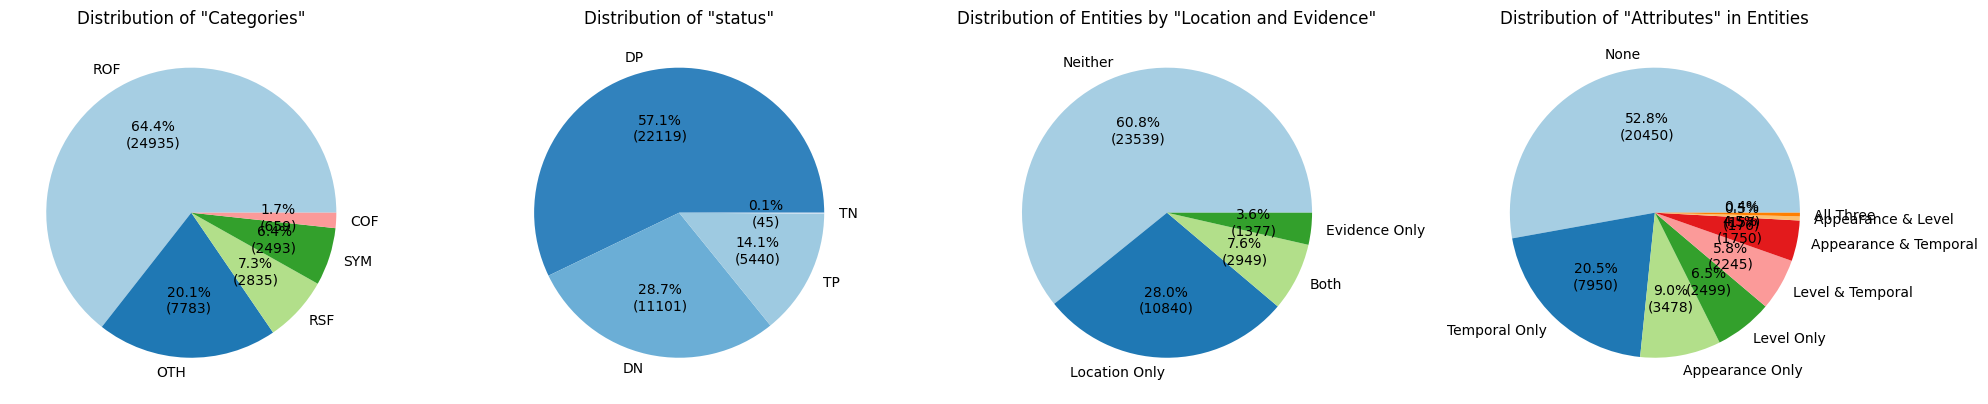

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure and three subplots (1 row x 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# First plot: Category ratios
cat_counts = df_final_filtered['cat'].value_counts()
axes[0].pie(cat_counts, labels=cat_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(cat_counts) / 100), colors=plt.cm.Paired(np.arange(len(cat_counts))))
axes[0].set_title('Distribution of "Categories"')
axes[0].set_ylabel('')  # Remove y-axis label for clarity

status_prefix_counts = df_final_filtered['status_prefix'].value_counts()

axes[1].pie(status_prefix_counts, labels=status_prefix_counts.index, 
        autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(status_prefix_counts) / 100), 
        colors=plt.cm.tab20c(np.arange(len(status_prefix_counts))))


axes[1].set_title('Distribution of "status"')

# Second plot: Distribution by Location and Evidence
conditions = [
    (df_final_filtered['location'].notna() & df_final_filtered['evidence'].notna()),
    (df_final_filtered['location'].notna() & df_final_filtered['evidence'].isna()),
    (df_final_filtered['location'].isna() & df_final_filtered['evidence'].notna()),
    (df_final_filtered['location'].isna() & df_final_filtered['evidence'].isna())
]
choices = ['Both', 'Location Only', 'Evidence Only', 'Neither']
df_final_filtered['status'] = np.select(conditions, choices, default='Neither')
status_counts = df_final_filtered['status'].value_counts()
axes[2].pie(status_counts, labels=status_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(status_counts) / 100), colors=plt.cm.Paired(np.arange(len(status_counts))))
axes[2].set_title('Distribution of Entities by "Location and Evidence"')

# Third plot: Distribution of Attributes
df_final_filtered['appearance'] = df_final_filtered[['morphology', 'distribution', 'size']].notna().any(axis=1)
df_final_filtered['level'] = df_final_filtered[['num', 'severity', 'comparision']].notna().any(axis=1)  # Correction on 'comparison'
df_final_filtered['temporal'] = df_final_filtered[['emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve']].notna().any(axis=1)
conditions = [
    (df_final_filtered['appearance'] & df_final_filtered['level'] & df_final_filtered['temporal']),
    (df_final_filtered['appearance'] & df_final_filtered['level'] & ~df_final_filtered['temporal']),
    (df_final_filtered['appearance'] & ~df_final_filtered['level'] & df_final_filtered['temporal']),
    (~df_final_filtered['appearance'] & df_final_filtered['level'] & df_final_filtered['temporal']),
    (df_final_filtered['appearance'] & ~df_final_filtered['level'] & ~df_final_filtered['temporal']),
    (~df_final_filtered['appearance'] & df_final_filtered['level'] & ~df_final_filtered['temporal']),
    (~df_final_filtered['appearance'] & ~df_final_filtered['level'] & df_final_filtered['temporal']),
    (~df_final_filtered['appearance'] & ~df_final_filtered['level'] & ~df_final_filtered['temporal'])
]
choices = [
    'All Three', 'Appearance & Level', 'Appearance & Temporal', 'Level & Temporal',
    'Appearance Only', 'Level Only', 'Temporal Only', 'None'
]
df_final_filtered['attribute_status'] = np.select(conditions, choices, default='None')
attribute_counts = df_final_filtered['attribute_status'].value_counts()
axes[3].pie(attribute_counts, labels=attribute_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(attribute_counts) / 100), colors=plt.cm.Paired(np.arange(len(attribute_counts))))
axes[3].set_title('Distribution of "Attributes" in Entities')

# Display the figure
plt.tight_layout()
plt.show()


### 환자별 시퀀스 길이 통계

In [71]:
print(len(df_final_filtered['patient_id'].unique()))
print(len(df_final_filtered['study_id'].unique()))
# df_final_filtered['patient_id'].unique()

293
3269


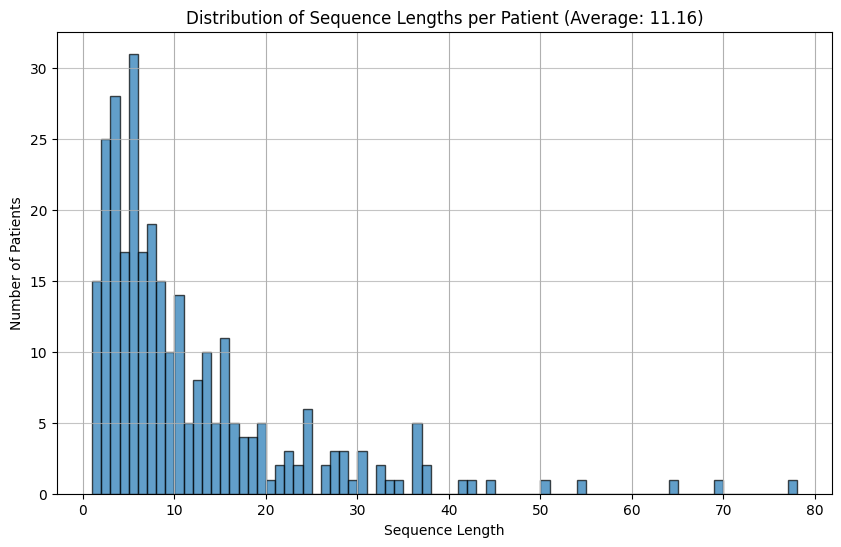

In [72]:
# Calculate the number of unique sequences per patient
sequence_lengths = df_final_filtered.groupby('patient_id')['sequence'].nunique()

# Calculate the average sequence length
average_length = sequence_lengths.mean()

# Plotting the distribution of sequence lengths
plt.figure(figsize=(10, 6))
sequence_lengths.hist(bins=range(min(sequence_lengths), max(sequence_lengths) + 1), edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Sequence Lengths per Patient (Average: {average_length:.2f})')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


### 어떤 케이스 샘플링?
1. 최대한 다양한 시나리오.

2. 시퀀스 2이상 10 이하인 환자에 대해 진행



# 기준 1. category별 normalized entity - status에 따라 구분.
## 목표: 다양한 상황의 환자들 샘플링.
## 케이스 1. major한 category (5 patient are focused on medical device status)
    1. 각 환자별 주로 언급이 이루어진 카테고리는? (OTH ratio vs ROF ratio vs RSF ratio)
        - 각 시퀀스에서 가장 많이 언급된 cateogry
        - 각 시퀀스 major category / 전체 시퀀스 갯수
        * ROF가 overstate하는 경향이 있어, 시퀀스별 계산
    * 결론: 6명의 환자가 OTH에 대한 언급이 Major statement로 존재.
    * 해석: 이 환자들은 적어도 질병을 찾기위한 관점보다 device에 대한 관심이 더 많았겠구나.



시퀀스가 2보다 크고 20보다 작은 환자에서 시퀀스별 TP, TN 누적합을 계산 후, 탐 10개의 환자를 본거.
=> 어려운 케이스라고 볼 수 있겠고,
총 몇명인지 카운트하고, 다음 기준에 따른 환자 샘플링 ㄱㄱ

샘플링된 환자들이 보유하는 질병 레이블 조사. 전체 대비 몇% 커버하는지
총 500-1000개 사이 리포트 샘플.

In [75]:
priority_order = ['OTH', 'RSF', 'ROF']

# 시퀀스별로 가장 많이 언급된 카테고리 찾기 및 빈도 계산
major_category_per_sequence = _2to_10_sequences_df.groupby(['patient_id', 'sequence', 'cat']).size().reset_index(name='mentions')
major_category_per_sequence = major_category_per_sequence.loc[major_category_per_sequence.groupby(['patient_id', 'sequence'])['mentions'].idxmax()]

# 환자별로 각 카테고리가 몇 번 major 카테고리로 선정되었는지 계산
major_counts_per_patient = major_category_per_sequence.groupby(['patient_id', 'cat']).size().reset_index(name='major_counts')
major_counts_per_patient = major_counts_per_patient.sort_values(by=['patient_id', 'major_counts'], ascending=[True, False])

# 환자별 총 시퀀스 수 계산
total_sequences_per_patient = _2to_10_sequences_df.groupby('patient_id')['sequence'].nunique().reset_index(name='total_sequences')

# 상위 2개 카테고리 및 비율 선택
def select_top_categories(group, total_sequences):
    cat1 = group.iloc[0]['cat'] if len(group) > 0 else None
    cat2 = group.iloc[1]['cat'] if len(group) > 1 else None
    percentage1 = (group.iloc[0]['major_counts'] / total_sequences * 100) if len(group) > 0 else None
    percentage2 = (group.iloc[1]['major_counts'] / total_sequences * 100) if len(group) > 1 else None
    return pd.Series([cat1, cat2, percentage1, percentage2, total_sequences], index=['cat1', 'cat2', 'percentage1', 'percentage2', 'total_sequences'])

top_categories_per_patient = major_counts_per_patient.groupby('patient_id').apply(lambda x: select_top_categories(x, total_sequences_per_patient.loc[total_sequences_per_patient['patient_id'] == x.iloc[0]['patient_id'], 'total_sequences'].values[0]))

# 환자별로 percentage가 50%인 경우, 주어진 우선순위에 따라 category 재할당
def assign_category_with_priority(group, priority_order):
    if group['percentage1'] == 50:
        for cat in priority_order:
            if cat in group[['cat1', 'cat2']].values:
                return cat
    return group['cat1']

top_categories_per_patient['final_cat'] = top_categories_per_patient.apply(assign_category_with_priority, priority_order=priority_order, axis=1)

display(top_categories_per_patient.head())
display(top_categories_per_patient[top_categories_per_patient['final_cat']=='OTH'])

# dev_cat_uni = set()
top_categories_per_patient = top_categories_per_patient.reset_index()
dev_cat_uni = set(top_categories_per_patient[top_categories_per_patient['final_cat']=='OTH']['patient_id'])

/tmp/ipykernel_3589217/3943405131.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_categories_per_patient = major_counts_per_patient.groupby('patient_id').apply(lambda x: select_top_categories(x, total_sequences_per_patient.loc[total_sequences_per_patient['patient_id'] == x.iloc[0]['patient_id'], 'total_sequences'].values[0]))


,cat1,cat2,percentage1,percentage2,total_sequences,final_cat
patient_id,,,,,,
p10032725,OTH,ROF,50.000000,50.000000,2,OTH
p10046166,ROF,COF,83.333333,16.666667,6,ROF
p10274145,ROF,None,100.000000,NaN,5,ROF
p10449297,ROF,None,100.000000,NaN,4,ROF
p10523725,ROF,RSF,88.888889,11.111111,9,ROF


,cat1,cat2,percentage1,percentage2,total_sequences,final_cat
patient_id,,,,,,
p10032725,OTH,ROF,50.0,50.0,2,OTH
p12810135,OTH,ROF,60.0,40.0,5,OTH
p15109122,OTH,ROF,50.0,50.0,4,OTH
p15161734,OTH,ROF,50.0,50.0,4,OTH
p15370732,OTH,ROF,75.0,25.0,4,OTH


## 케이스 2. location or evidence가 많은 케이스. 16 patients
    1. 열심히 location을 달아준 경우 이를 기반으로 더 구체화할수 있음.
    2. 충실히 finding에 대한 evidence를 달아준 경우. => 각 finding에 대한 근거를 연결 할 수 있음.

Location noramlize 해야하는데, 이는 과거 Level을 기반으로 분류했던 체계를 도입. 29개의 body part

Intersection of Top 10 Patients in Both Categories:
patients_with_2_to_10_sequences 176
16
{'p19757720', 'p19844485', 'p13291370', 'p12074041', 'p15378103', 'p12124741', 'p18067737', 'p16672854', 'p13849733', 'p12702423', 'p13067703', 'p19565388', 'p12410066', 'p19640059', 'p15840907', 'p14969719'}
-----------------------------------


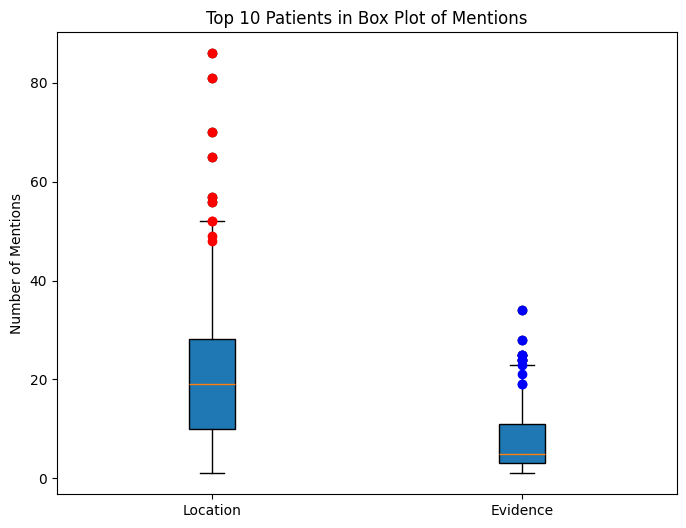

Average Location Mentions: 21.352272727272727
Average Evidence Mentions: 7.440476190476191
Top 10 Location Patients are in the top 5.68%
Top 10 Evidence Patients are in the top 5.95%


In [94]:
top_k_val = 10
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient < 11)].index

# Step 1: Count 'TN' and 'TP' mentions for each patient
_2to_10_sequnces_df = df_final_filtered[df_final_filtered['patient_id'].isin(patients_with_2_to_10_sequences)]

location_df = _2to_10_sequnces_df[_2to_10_sequnces_df['location'].notna()][['patient_id', 'study_id','ent','status_prefix', 'sequence','location']]
evidence_df = _2to_10_sequnces_df[_2to_10_sequnces_df['evidence'].notna()][['patient_id', 'study_id','ent','status_prefix', 'sequence','evidence']]

# location과 evidence의 등장 횟수 및 비율 계산 함수 정의
def calculate_counts_and_ratios(df, entity_column):
    # 시퀀스 단위로 각 entity의 등장 횟수 계산
    count_df = df.groupby(['patient_id', 'study_id', 'sequence'])[entity_column].count().reset_index(name='count')
    # 전체 entity 수 계산 (모든 entity 갯수의 합계)
    total_entities = df.groupby(['patient_id', 'study_id', 'sequence']).size().reset_index(name='total_entities')
    # 데이터 병합
    analysis_df = pd.merge(count_df, total_entities, on=['patient_id', 'study_id', 'sequence'])
    # 등장 비율 계산
    analysis_df['ratio'] = analysis_df['count'] / analysis_df['total_entities']
    return analysis_df

# location과 evidence 데이터에 대해 함수 적용
location_analysis = calculate_counts_and_ratios(location_df, 'location')
evidence_analysis = calculate_counts_and_ratios(evidence_df, 'evidence')

# 환자별로 시퀀스 내 절대적인 등장 횟수의 총합 계산
location_totals = location_analysis.groupby('patient_id')['count'].sum().reset_index(name='total_location_count')
evidence_totals = evidence_analysis.groupby('patient_id')['count'].sum().reset_index(name='total_evidence_count')

# 시퀀스 개수 계산
location_sequence_count = location_df.groupby('patient_id')['sequence'].nunique().reset_index(name='sequence_count')
evidence_sequence_count = evidence_df.groupby('patient_id')['sequence'].nunique().reset_index(name='sequence_count')

# 데이터 병합
location_totals = pd.merge(location_totals, location_sequence_count, on='patient_id')
evidence_totals = pd.merge(evidence_totals, evidence_sequence_count, on='patient_id')

# top 10 환자 추출
top10_location_patients = location_totals.nlargest(top_k_val, 'total_location_count')
top10_evidence_patients = evidence_totals.nlargest(top_k_val, 'total_evidence_count')

# print("Top 10 Patients by Location Mentions:")
# print(top10_location_patients)
# print("\nTop 10 Patients by Evidence Mentions:")
# print(top10_evidence_patients)

set_evidence_patients = set(top10_evidence_patients['patient_id'])
set_location_patients = set(top10_location_patients['patient_id'])

# 두 set의 교집합 계산
relation_uni = set_evidence_patients.union(set_location_patients)

# 결과 출력
print("Intersection of Top 10 Patients in Both Categories:")
print("patients_with_2_to_10_sequences", len(patients_with_2_to_10_sequences))
print(len(relation_uni))
print(relation_uni)
print("-----------------------------------")

def calculate_totals_and_sequence_counts(analysis_df, original_df):
    totals = analysis_df.groupby('patient_id')['count'].sum().reset_index(name='total_count')
    sequence_count = original_df.groupby('patient_id')['sequence'].nunique().reset_index(name='sequence_count')
    combined_totals = pd.merge(totals, sequence_count, on='patient_id')
    return combined_totals

# 각 카테고리에 대한 데이터 계산
combined_location_totals = calculate_totals_and_sequence_counts(location_analysis, location_df)
combined_evidence_totals = calculate_totals_and_sequence_counts(evidence_analysis, evidence_df)

location_data = combined_location_totals['total_count']
evidence_data = combined_evidence_totals['total_count']

# 박스플롯 생성
fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot([location_data, evidence_data], labels=['Location', 'Evidence'], patch_artist=True)

def plot_top_patients(patient_ids, data, category_index, color):
    for patient_id in patient_ids:
        if patient_id in data['patient_id'].values:
            patient_index = data[data['patient_id'] == patient_id].index[0]
            plt.scatter(category_index, data.loc[patient_index, 'total_count'], color=color, zorder=3)
        else:
            print("patient_id", patient_id)

plot_top_patients(top10_location_patients['patient_id'], combined_location_totals, 1, 'red')
plot_top_patients(top10_evidence_patients['patient_id'], combined_evidence_totals, 2, 'blue')


ax.set_title('Top 10 Patients in Box Plot of Mentions')
ax.set_ylabel('Number of Mentions')

plt.show()
# 평균 언급 횟수
average_location_mentions = combined_location_totals['total_count'].mean()
average_evidence_mentions = combined_evidence_totals['total_count'].mean()
print(f"Average Location Mentions: {average_location_mentions}")
print(f"Average Evidence Mentions: {average_evidence_mentions}")

# top 10 환자 추출 및 해당 환자들이 전체 대비 상위 몇 퍼센트인지 계산
def calculate_top_k_percent(top_k_df, combined_totals):
    top_k_val = len(top_k_df)
    percent = (top_k_val / len(combined_totals) * 100)
    return percent

percent_location = calculate_top_k_percent(top10_location_patients, combined_location_totals)
percent_evidence = calculate_top_k_percent(top10_evidence_patients, combined_evidence_totals)

print(f"Top 10 Location Patients are in the top {percent_location:.2f}%")
print(f"Top 10 Evidence Patients are in the top {percent_evidence:.2f}%")


In [91]:
combined_location_totals, combined_evidence_totals
top10_location_patients
# combined_location_totals[combined_location_totals['patient_id'] == 'p13849733']
# combined_location_totals
# location_data
top10_location_patients

,patient_id,total_location_count,sequence_count
61,p13849733,86,9
142,p18067737,81,9
47,p13067703,70,10
36,p12410066,65,10
41,p12702423,57,9
80,p14969719,56,8
29,p12124741,52,7
162,p19565388,52,10
95,p15378103,49,10
50,p13291370,48,10


## 케이스 3. attribute가 많은 케이스.  26 patients
    1. finding에 대한 enrich한 정보가 많이 들어있는 경우.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 Patients by Morphology, Distribution, and Size Features:
-----------------------------------
Top 10 Patients by num, severity, and comparision Features:
-----------------------------------
-----------------------------------
p12303667
features_data[feature] [5, 10, 9, 6, 12]
p13067703
features_data[feature] [5, 10, 9, 6, 12]
p15612622
features_data[feature] [5, 10, 9, 6, 12]
p19800337
features_data[feature] [5, 10, 9, 6, 12]
p14794396
features_data[feature] [5, 10, 9, 6, 12]
p11512104
features_data[feature] [5, 10, 9, 6, 12]
p16050730
features_data[feature] [5, 10, 9, 6, 12]
p17720924
features_data[feature] [5, 10, 9, 6, 12]
p18835687
features_data[feature] [5, 10, 9, 6, 12]
p19389547
features_data[feature] [5, 10, 9, 6, 12]
p16672854
features_data[feature] [9, 9, 7, 21, 12]
p12110863
features_data[feature] [9, 9, 7, 21, 12]
p12074041
features_data[feature] [9, 9, 7, 21, 12]
p14969719
features_data[feature] [9, 9, 7, 21, 12]
p11893091
features_data[feature] [9, 9, 7, 21, 12]
p12

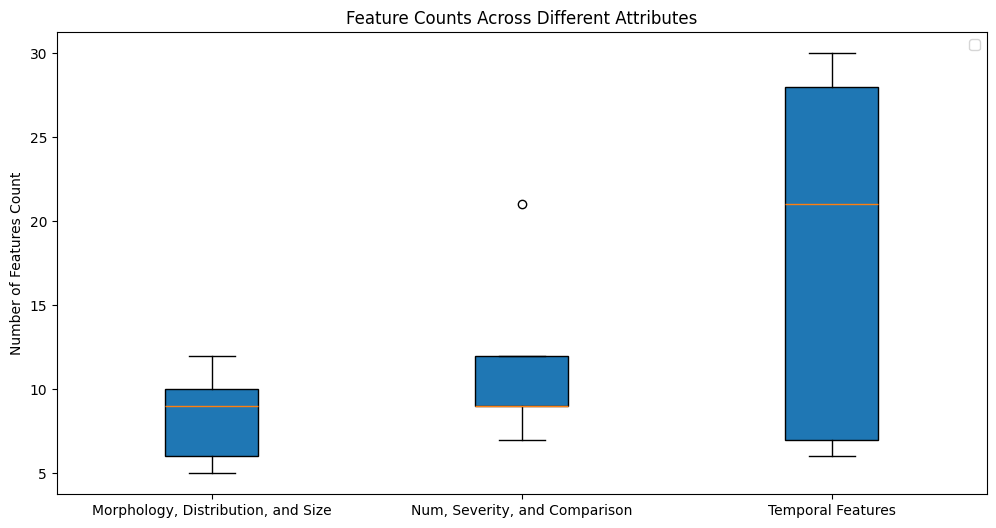

In [119]:
top_k_value = 10

# pd.set_option('display.max_rows', 500)

# 각 시퀀스별로 전체 entity 수 및 해당 특성을 갖는 entity 수 계산
def count_features_and_entities(df, features):
    # 각 feature에 대해 notna 결과를 추출하고, 행 방향으로 더해서 하나라도 True이면 1이 되도록 함
    df['feature_present'] = df[features].notna().any(axis=1).astype(int)
    # 각 시퀀스에 대해 feature가 존재하는 entity 수 계산
    feature_counts = df.groupby(['patient_id', 'study_id', 'sequence'])['feature_present'].sum().reset_index(name='feature_count')
    # 각 시퀀스에 대한 전체 entity 수 계산
    total_entities = df.groupby(['patient_id', 'study_id', 'sequence']).size().reset_index(name='total_entities')
    # 데이터 병합
    analysis_df = pd.merge(feature_counts, total_entities, on=['patient_id', 'study_id', 'sequence'])
    # 등장 비율 계산
    analysis_df['ratio'] = analysis_df['feature_count'] / analysis_df['total_entities']
    return analysis_df

# 상위 K명의 환자 추출하는 함수 정의
def get_top_k_patients(df, k):
    return df.nlargest(k, 'feature_count')


###################### appr
aprr_df = _2to_10_sequences_df[
    _2to_10_sequences_df['morphology'].notna() |
    _2to_10_sequences_df['distribution'].notna() |
    _2to_10_sequences_df['size'].notna()
][['patient_id', 'study_id', 'ent', 'status_prefix', 'sequence', 'morphology', 'distribution', 'size']]

appr_analysis = count_features_and_entities(aprr_df, ['morphology', 'distribution', 'size'])

# 전체 환자별로 feature가 존재하는 entity의 총합과 시퀀스 개수 계산
appr_patient_feature_summary = appr_analysis.groupby('patient_id').agg({
    'feature_count': 'sum',
    'sequence': 'nunique'
}).reset_index().rename(columns={'sequence': 'sequence_count'})

# 상위 10명의 환자 추출 (K=10)
top_10_morph_patients = get_top_k_patients(appr_patient_feature_summary, top_k_value)


# 결과 출력
print("Top 10 Patients by Morphology, Distribution, and Size Features:")
# print(top_10_morph_patients)
# print("\nDetailed Morphology, Distribution, and Size Analysis:")
# print(appr_analysis)
# display(morph_analysis[morph_analysis['ratio']!=1])
print("-----------------------------------")
######################## level 
level_df = _2to_10_sequences_df[_2to_10_sequences_df['num'].notna() |
    _2to_10_sequences_df['severity'].notna() |
    _2to_10_sequences_df['comparision'].notna()
][['patient_id', 'study_id', 'ent', 'status_prefix', 'sequence', 'num', 'severity', 'comparision']]

level_analysis = count_features_and_entities(level_df, ['num', 'severity', 'comparision'])

# 전체 환자별로 feature가 존재하는 entity의 총합과 시퀀스 개수 계산
level_patient_feature_summary = level_analysis.groupby('patient_id').agg({
    'feature_count': 'sum',
    'sequence': 'nunique'
}).reset_index().rename(columns={'sequence': 'sequence_count'})

# 상위 10명의 환자 추출 (K=10)
top_10_level_patients = get_top_k_patients(level_patient_feature_summary, top_k_value)

print("Top 10 Patients by num, severity, and comparision Features:")
# print(top_10_level_patients)
# print("\nDetailed num, severity, and comparision Analysis:")
# print(appr_analysis)
print("-----------------------------------")

######################## temporal 

tmp_df = _2to_10_sequences_df[
    _2to_10_sequences_df['emerge'].notna() |
    _2to_10_sequences_df['no change'].notna() |
    _2to_10_sequences_df['improved'].notna() |
    _2to_10_sequences_df['worsened'].notna() |
    _2to_10_sequences_df['reposition'].notna() |
    _2to_10_sequences_df['resolve'].notna()
][['patient_id', 'study_id', 'ent', 'status_prefix', 'sequence', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve']]

tmp_analysis = count_features_and_entities(tmp_df, ['emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve'])

# 전체 환자별로 feature가 존재하는 entity의 총합과 시퀀스 개수 계산
tmp_patient_feature_summary = tmp_analysis.groupby('patient_id').agg({
    'feature_count': 'sum',
    'sequence': 'nunique'
}).reset_index().rename(columns={'sequence': 'sequence_count'})

# 상위 10명의 환자 추출 (K=10)
top_10_tmp_patients = get_top_k_patients(tmp_patient_feature_summary, top_k_value)


# print("Top 10 Patients by emerge, no change, and improved Features:")
# print(top_10_tmp_patients)
# print("\nDetailed emerge, no change, and improved Analysis:")
# print(appr_analysis)
print("-----------------------------------")

set_morph_patients = set(top_10_morph_patients['patient_id'])
set_level_patients = set(top_10_level_patients['patient_id'])
set_tmp_patients = set(top_10_tmp_patients['patient_id'])

# 두 set의 교집합 계산
uni_patients_1 = set_level_patients.union(set_morph_patients)
attribute_uni = set_tmp_patients.union(uni_patients_1)

# 결과 출력
# print("Intersection of Top 10 Patients in Both Categories:")
# print("patients_with_2_to_20_sequences", len(patients_with_2_to_20_sequences))
# print("attribute patients", len(attribute_uni))
# print(attribute_uni)
# print("-----------------------------------")


features_data = {
    'Morphology, Distribution, and Size': [appr_patient_feature_summary['feature_count'][i] for i in range(5)],
    'Num, Severity, and Comparison': [level_patient_feature_summary['feature_count'][i] for i in range(5, 10)],
    'Temporal Features': [tmp_patient_feature_summary['feature_count'][i] for i in range(10, 15)]
}

# 플롯 생성
fig, ax = plt.subplots(figsize=(12, 6))

# 각 특성 그룹에 대해 박스 플롯
positions = [1, 2, 3]
labels = list(features_data.keys())
data_lists = list(features_data.values())

# 박스 플롯 생성
bp = ax.boxplot(data_lists, positions=positions, labels=labels, patch_artist=True)

top_patients = [list(top_10_morph_patients['patient_id']), list(top_10_level_patients['patient_id']), list(top_10_tmp_patients['patient_id'])]

# 각 특성 그룹별 상위 10명의 환자 위치 표시
# colors = ['red', 'blue', 'green']
# for idx, feature in enumerate(labels):

#     top_patient_ids = top_patients[idx]
#     print("top_patient_ids", top_patient_ids)
#     print("feature", features_data[feature])
#     for pid in top_patient_ids:
#         print("pid",pid)
#         print(features_data[feature][pid])
#     input("ST")
#     # 실제 데이터셋에서 환자의 feature count 추출
#     # if idx == 0:
#     #     patient_feature_summary = appr_patient_feature_summary
#     # elif idx ==1 :
#     #     patient_feature_summary = level_patient_feature_summary
#     # else:
#     #     patient_feature_summary = tmp_patient_feature_summary
        
#     top_patient_counts = [features_data[feature][pid - 1] for pid in top_patient_ids if pid - 1 < len(features_data[feature])]
#     plt.scatter([idx + 1] * len(top_patient_counts), top_patient_counts, color=colors[idx], label=f"Top patients in {feature}")

# # 범례 및 기타 그래프 세팅
# plt.legend()
# plt.title('Feature Counts Across Different Attributes')
# plt.ylabel('Number of Features Count')

# plt.show()
colors = ['red', 'blue', 'green']

for idx, itr_patient in enumerate(top_patients):
    feature = labels[idx]
    for patient_id in itr_patient:
        if patient_id in features_data[feature]:
            patient_count = features_data[feature][patient_id]
            plt.scatter(idx + 1, patient_count, color=colors[idx], label=f"Patient {patient_id}")
        else:
            print(patient_id)
            print("features_data[feature]", features_data[feature])
# 범례 및 기타 그래프 세팅
plt.legend()
plt.title('Feature Counts Across Different Attributes')
plt.ylabel('Number of Features Count')

plt.show()


## 케이스 4. Other information이 있는 경우. 18 patients
    1. technical limitation?
        10% 스터디에서 technical limitation이 추출됨.
        - 'no prior', 'ap portable view', 'single portal view', 'decubitus films' 등 모든 technical limitation에 관련될 수 있는 내용이 모두 담기고 있음.
        - 이를 manually 없애고, 직접적으로 poor, missing, not include 등 명시적인 technical limitation이 있는 경우들만 추림.      


    2. other source?
        전체 9% 스터디는 other source. (ex. biopsy|thoracentesis|supine|ct)

    3. past hx?
        전체 82% study 너무 많은 숫자. 과연 정말 다 past hx? 
        그러나 이를 골라내기 어려움. (consolidation등의 history section에 등장하는 내용도 현재는 여기에 분류된다고 해도 잘못된게 아니기 때문.)
        차라리 수술명만 따로 넣거나 아예 이 섹션을 빼버리는방법

In [114]:
technical_limit_df = _2to_10_sequences_df[_2to_10_sequences_df['technical limitation'].notna()][['patient_id', 'study_id','ent','status_prefix', 'sequence','technical limitation']]
print("technical limit", len(technical_limit_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

def get_top_k_patients(df, k, feature):
    return df.nlargest(k, feature)

sequence_counts = _2to_10_sequences_df.groupby('patient_id')['sequence'].nunique().reset_index(name='total_sequence')

#----------------------------------------------------------------------------------
included_df = technical_limit_df[technical_limit_df['technical limitation'].str.contains('out|off|rotat|position|poor|miss|not inclu|technique|limit|difficult|artifact|obscu|incompl|partial|motion|inclu|not see|not well|under|degradation|field of view', na=False, regex=True)]
excluded_df = technical_limit_df[~technical_limit_df['technical limitation'].str.contains('out|off|rotat|position|poor|miss|not inclu|technique|limit|difficult|artifact|obscu|incompl|partial|motion|inclu|not see|not well|under|degradation|field of view', na=False, regex=True)]

# 제외된 데이터의 'technical limitation' 컬럼에서 고유값 확인
print(len(included_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

included_df = count_features_and_entities(included_df, ['technical limitation'])

# 환자별로 feature가 존재하는 entity의 총합과 해당 환자의 전체 시퀀스 개수 계산
patient_feature_summary = included_df.groupby('patient_id').agg({
    'feature_count': 'sum'
}).reset_index()
showing_sequence_counts = included_df.groupby('patient_id')['sequence'].nunique().reset_index(name='show_sequence')

# 환자별 전체 시퀀스 수 계산
final_patient_summary = pd.merge(patient_feature_summary, showing_sequence_counts, on='patient_id')
final_patient_summary = pd.merge(final_patient_summary, sequence_counts, on='patient_id')

# 상위 10명의 환자 추출 (K=10)
top_10_patients = get_top_k_patients(final_patient_summary, 10, 'show_sequence')

print(top_10_patients)

set_tech_patients = set(top_10_patients['patient_id'])
print("---")

#----------------------------------------------------------------------------------

other_source_df = _2to_10_sequences_df[_2to_10_sequences_df['other source'].notna()][['patient_id', 'study_id','ent','status_prefix', 'sequence','other source']]
print("other source", len(other_source_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

included_df = other_source_df[other_source_df['other source'].str.contains('biopsy|thoracentesis|supine|ct|pet|ekg|medical record|ultrasound|vbg|pathology|bal|dialysis|echocardiography|barium examination|fluoroscopy|bronchoscopy|dedicated clavicular films|shoulder radiographs|outside hospital', na=False, regex=True)]
excluded_df = other_source_df[~other_source_df['other source'].str.contains('biopsy|thoracentesis|supine|ct|pet|ekg|medical record|ultrasound|vbg|pathology|bal|dialysis|echocardiography|barium examination|fluoroscopy|bronchoscopy|dedicated clavicular films|shoulder radiographs|outside hospital', na=False, regex=True)]

# 제외된 데이터의 'technical limitation' 컬럼에서 고유값 확인
print(len(included_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

included_df = count_features_and_entities(included_df, ['other source'])

# 환자별로 feature가 존재하는 entity의 총합과 해당 환자의 전체 시퀀스 개수 계산
patient_feature_summary = included_df.groupby('patient_id').agg({
    'feature_count': 'sum'
}).reset_index()
showing_sequence_counts = included_df.groupby('patient_id')['sequence'].nunique().reset_index(name='show_sequence')

# 환자별 전체 시퀀스 수 계산
final_patient_summary = pd.merge(patient_feature_summary, showing_sequence_counts, on='patient_id')
final_patient_summary = pd.merge(final_patient_summary, sequence_counts, on='patient_id')

# 상위 10명의 환자 추출 (K=10)
top_10_patients = get_top_k_patients(final_patient_summary, 10, 'show_sequence')

print(top_10_patients)

set_other_source_patients = set(top_10_patients['patient_id'])
print("---")
#----------------------------------------------------------------------------------

# past_hx_df = _2to_10_sequences_df[_2to_10_sequences_df['past hx'].notna()][['patient_id', 'study_id','ent','status_prefix', 'sequence','past hx']]
# # print(len(past_hx_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

# included_df = past_hx_df[past_hx_df['past hx'].str.contains('', na=False, regex=True)]
# excluded_df = past_hx_df[~past_hx_df['past hx'].str.contains('', na=False, regex=True)]

# # 제외된 데이터의 'technical limitation' 컬럼에서 고유값 확인
# print(len(included_df['study_id'].unique())/len(_2to_10_sequences_df['study_id'].unique()))

# included_df = count_features_and_entities(included_df, ['past hx'])

# # 환자별로 feature가 존재하는 entity의 총합과 해당 환자의 전체 시퀀스 개수 계산
# patient_feature_summary = included_df.groupby('patient_id').agg({
#     'feature_count': 'sum'
# }).reset_index()

# # 환자별 전체 시퀀스 수 계산
# final_patient_summary = pd.merge(patient_feature_summary, sequence_counts, on='patient_id')

# # 상위 10명의 환자 추출 (K=10)
# top_10_patients = get_top_k_patients(final_patient_summary, 10)

# 두 set의 교집합 계산
others_uni = set_tech_patients.union(set_other_source_patients)
# print("len(set_tech_patients)", len(set_tech_patients))
# print("len(set_other_source_patients)", len(set_other_source_patients))
print("others_uni", len(others_uni))
print("---")



technical limit 0.14968152866242038
0.1029723991507431
   patient_id  feature_count  show_sequence  total_sequence
3   p10886362              6              4              10
23  p13700088              5              4               9
67  p19757720              3              3              10
1   p10532326              2              2               5
2   p10885696              5              2               8
6   p11569042              3              2               8
8   p11906222              3              2               6
11  p12074041              2              2              10
15  p12702423              3              2               9
17  p13023326              2              2               4
---
other source 0.17940552016985137
0.09660297239915075
   patient_id  feature_count  show_sequence  total_sequence
0   p10046166              6              3               6
10  p11879886              4              3               6
16  p12702423             16              3     

/tmp/ipykernel_2569828/430986815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feature_present'] = df[features].notna().any(axis=1).astype(int)
/tmp/ipykernel_2569828/430986815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['feature_present'] = df[features].notna().any(axis=1).astype(int)


### Case5. Status analysis. 1st axis (Positive vs Negative), 2nd axis (Certain vs Unceratin) ratio

Category: pos_mean_OTH, Closest Patients IDs: ['p10523725', 'p12136799', 'p12433541', 'p15541869', 'p14213287', 'p15881535', 'p15896572', 'p17396677', 'p19404187', 'p16409152']
Category: pos_mean_ROF, Closest Patients IDs: ['p15438386', 'p13473781', 'p12733339', 'p19894745', 'p13023326', 'p10449297', 'p16622813', 'p15612622', 'p18978682', 'p14147380']
Category: pos_mean_RSF, Closest Patients IDs: ['p10532326', 'p11540283', 'p11893091', 'p15518538', 'p19159236', 'p16015751', 'p17398573', 'p17439310', 'p19757720', 'p17147859']
Category: dpdn_mean_OTH, Closest Patients IDs: ['p12303667', 'p19404187', 'p16622813', 'p10532326', 'p12074041', 'p10754184', 'p12810135', 'p11893091', 'p15207316', 'p14147380']
Category: dpdn_mean_ROF, Closest Patients IDs: ['p17897339', 'p16059470', 'p18343726', 'p16409152', 'p14722763', 'p12074041', 'p16524406', 'p19389041', 'p13023326', 'p12110863']
Category: dpdn_mean_RSF, Closest Patients IDs: ['p10959054', 'p19389547', 'p18067737', 'p10754184', 'p12110863', 

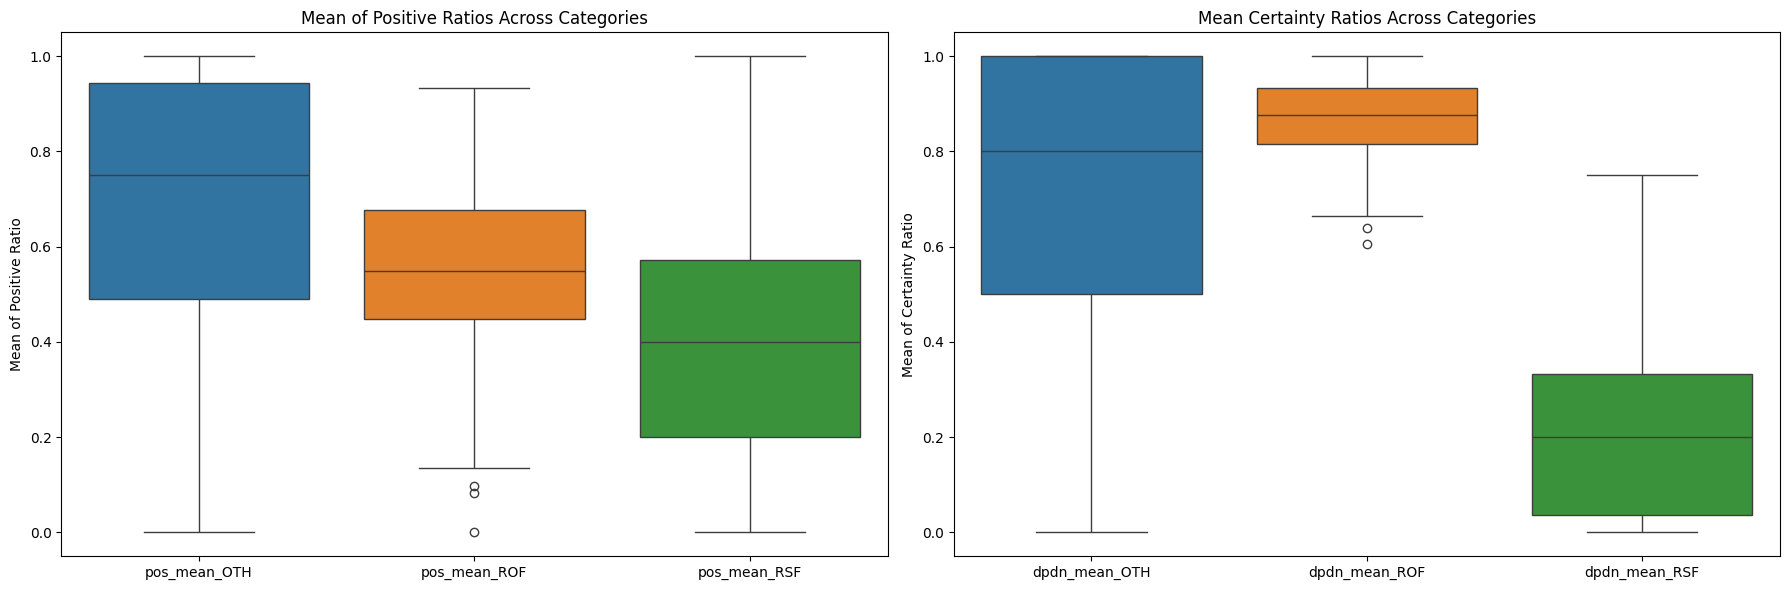

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# categories = ['OTH', 'ROF', 'COF', 'SYM', 'RSF']
categories = ['OTH', 'ROF', 'RSF']
variability_measures = []

for patient_id in _2to_10_sequences_df['patient_id'].unique():
    patient_data = _2to_10_sequences_df[_2to_10_sequences_df['patient_id'] == patient_id]
    unique_sequences = patient_data['sequence'].unique()

    # Create a DataFrame indexed by sequence and category
    index = pd.MultiIndex.from_product([unique_sequences, categories], names=['sequence', 'cat'])
    certainty_data = pd.DataFrame(index=index, columns=['Certainty'], dtype='float').fillna(0.0)  # Explicitly specifying data type
    posneg_data = pd.DataFrame(index=index, columns=['posneg'], dtype='float').fillna(0.0)  # Explicitly specifying data type

    # Fill in certainty values
    for sequence in unique_sequences:
        sequence_data = patient_data[patient_data['sequence'] == sequence]
        for category in categories:
            category_data = sequence_data[sequence_data['cat'] == category]
            dp_dn_count = category_data[category_data['status_prefix'].isin(['DP', 'DN'])].shape[0]
            pn_count = category_data[category_data['status_prefix'].isin(['DP', 'TP'])].shape[0]
            total_count = category_data.shape[0]
            if total_count > 0:
                certainty_ratio = dp_dn_count / total_count
                pn_ratio = pn_count / total_count
                certainty_data.at[(sequence, category), 'Certainty'] = certainty_ratio
                posneg_data.at[(sequence, category), 'posneg'] = pn_ratio
                

    # Remove all NaN entries (sequences without data)
    certainty_data = certainty_data.dropna()
    posneg_data = posneg_data.dropna()

    # Calculate variability (standard deviation and mean)
    if not certainty_data.empty:
        mean_val = certainty_data.unstack('cat')['Certainty'].mean()
        mean_val2 = posneg_data.unstack('cat')['posneg'].mean()
        
        variability_data = pd.DataFrame({
            'patient_id': [patient_id],
            'pos_mean_OTH': [mean_val2.get('OTH', None)],
            'pos_mean_ROF': [mean_val2.get('ROF', None)],
            # 'pos_mean_COF': [mean_val2.get('COF', None)],
            # 'pos_mean_SYM': [mean_val2.get('SYM', None)],
            'pos_mean_RSF': [mean_val2.get('RSF', None)],
            'dpdn_mean_OTH': [mean_val.get('OTH', None)],
            'dpdn_mean_ROF': [mean_val.get('ROF', None)],
            # 'dpdn_mean_COF': [mean_val.get('COF', None)],
            # 'dpdn_mean_SYM': [mean_val.get('SYM', None)],
            'dpdn_mean_RSF': [mean_val.get('RSF', None)]
        })

        variability_measures.append(variability_data)

# Concatenate all variability data into one DataFrame
if variability_measures:
    variability_measures = pd.concat(variability_measures).set_index('patient_id')
    
    # 카테고리 정의
    categories = [col for col in variability_measures.columns if 'mean_' in col]
    
    # 각 카테고리별로 평균에 가장 가까운 환자 계산
    closest_patients = {}
    for category in categories:
        mean_value = variability_measures[category].mean()
        differences = np.abs(variability_measures[category] - mean_value)
        closest_indices = differences.nsmallest(10).index
        closest_patients[category] = variability_measures.loc[closest_indices]

    # 가장 가까운 환자들의 정보 출력
    avg_set_uni = set()
    for cat, data in closest_patients.items():
        print(f"Category: {cat}, Closest Patients IDs: {data.index.tolist()}")
        avg_set_uni.update(data.index.tolist())
    
    print("\n")
    # Print unique patient IDs
    print(f"Unique {len(avg_set_uni)} patient IDs across all categories: {avg_set_uni}")
    
    print("\n")
    
    # Boxplot을 사용한 시각화
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.boxplot(data=variability_measures.filter(like='pos_mean_'), ax=axes[0])
    axes[0].set_title('Mean of Positive Ratios Across Categories')
    axes[0].set_ylabel('Mean of Positive Ratio')

    sns.boxplot(data=variability_measures.filter(like='dpdn_mean_'), ax=axes[1])
    axes[1].set_title('Mean Certainty Ratios Across Categories')
    axes[1].set_ylabel('Mean of Certainty Ratio')

    plt.tight_layout()
    plt.show()

else:
    print("No data available for plotting.")


In [156]:
# 주어진 다섯 개의 세트를 통합
all_unique_patients = avg_set_uni.union(others_uni, attribute_uni, relation_uni, dev_cat_uni)

# 통합된 세트에서 유니크한 patient_id의 수
print("Total unique patient_ids:", len(all_unique_patients))

# df_final_filtered에서 해당 patient_id를 가진 환자들만 필터링
final_patient_data = df_final_filtered[df_final_filtered['patient_id'].isin(all_unique_patients)]

# 결과 데이터프레임 출력
display(final_patient_data.drop_duplicates(['study_id']))


Total unique patient_ids: 81


,patient_id,study_id,sequence,sec,report,sent,ent,cat,status,location,...,radlex_ent,radlex_ent_path,radlex_ent_code,status_prefix,status_suffix,ontology_norm,appearance,level,temporal,attribute_status
0,p10032725,s50331901,1,HIST,Intubated-year-old woman. Check tube placement.,Intubated-year-old woman. Check tube placement.,Intubated,OTH,Neither,NaN,...,NaN,NaN,NaN,DP,,Intubated,False,False,False,None
6,p10032725,s55504914,2,HIST,ET tube advanced.,ET tube advanced.,endotracheal tube,OTH,Neither,NaN,...,tube,"['tube or catheter', 'implantable device', 'me...",RID5555,DP,advanced,Endotracheal tube,False,False,False,None
12,p10046166,s56173345,1,HIST,Evaluation of the patient with intracranial he...,Evaluation of the patient with intracranial he...,intracranial hemorrhage,COF,Neither,NaN,...,NaN,NaN,NaN,DP,Evaluation of the patient,Intracranial Hemorrhage,False,False,False,None
21,p10046166,s57977208,2,HIST,"Post-procedure, to assess for pneumothorax.","Post-procedure, to assess for pneumothorax.",pneumothorax,ROF,Neither,NaN,...,pneumothorax,"['respiratory disorder', 'body-system-specific...",RID5352,TP,to assess for,Pneumothorax,False,False,False,None
25,p10046166,s53492798,3,HIST,-year-old male with history of metastatic mela...,-year-old male with history of metastatic mela...,metastatic melanoma,OTH,Neither,NaN,...,NaN,NaN,NaN,DP,history of,Metastatic melanoma,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38051,p13700088,s59646245,9,HIST,-year-old female with weakness.,-year-old female with weakness.,weakness,SYM,Neither,NaN,...,NaN,NaN,NaN,DP,,Weakness,False,False,False,None
38211,p15161734,s54589789,1,HIST,"Shortness of breath and wheezing, to assess fo...","Shortness of breath and wheezing, to assess fo...",shortness of breath,SYM,Neither,NaN,...,NaN,NaN,NaN,DP,,No Shortness of Breath,False,False,False,None
38223,p15161734,s57523636,2,HIST,Patient intubated. Evaluate for pneumonia.,Patient intubated. Evaluate for pneumonia.,intubated,OTH,Neither,NaN,...,NaN,NaN,NaN,DP,Patient intubated,Intubated,False,False,False,None
38243,p15161734,s57529728,3,HIST,Line placement.,Line placement.,Line placement,OTH,Neither,NaN,...,NaN,NaN,NaN,DP,,Placement,False,False,False,None


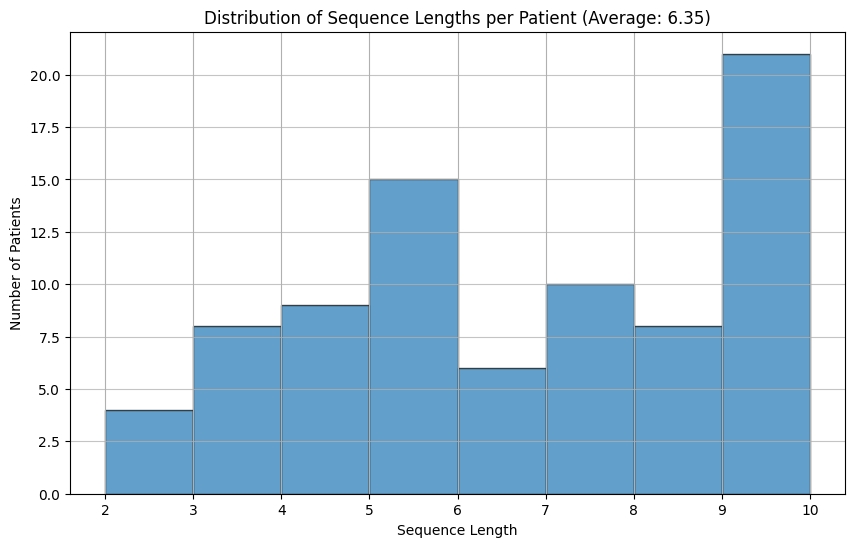

In [157]:
# Calculate the number of unique sequences per patient
sequence_lengths = final_patient_data.groupby('patient_id')['sequence'].nunique()

# Calculate the average sequence length
average_length = sequence_lengths.mean()

# Plotting the distribution of sequence lengths
plt.figure(figsize=(10, 6))
sequence_lengths.hist(bins=range(min(sequence_lengths), max(sequence_lengths) + 1), edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Sequence Lengths per Patient (Average: {average_length:.2f})')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


/tmp/ipykernel_2569828/540900288.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_patient_data['status'] = np.select(conditions, choices, default='Neither')
/tmp/ipykernel_2569828/540900288.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_patient_data['appearance'] = final_patient_data[['morphology', 'distribution', 'size']].notna().any(axis=1)
/tmp/ipykernel_2569828/540900288.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

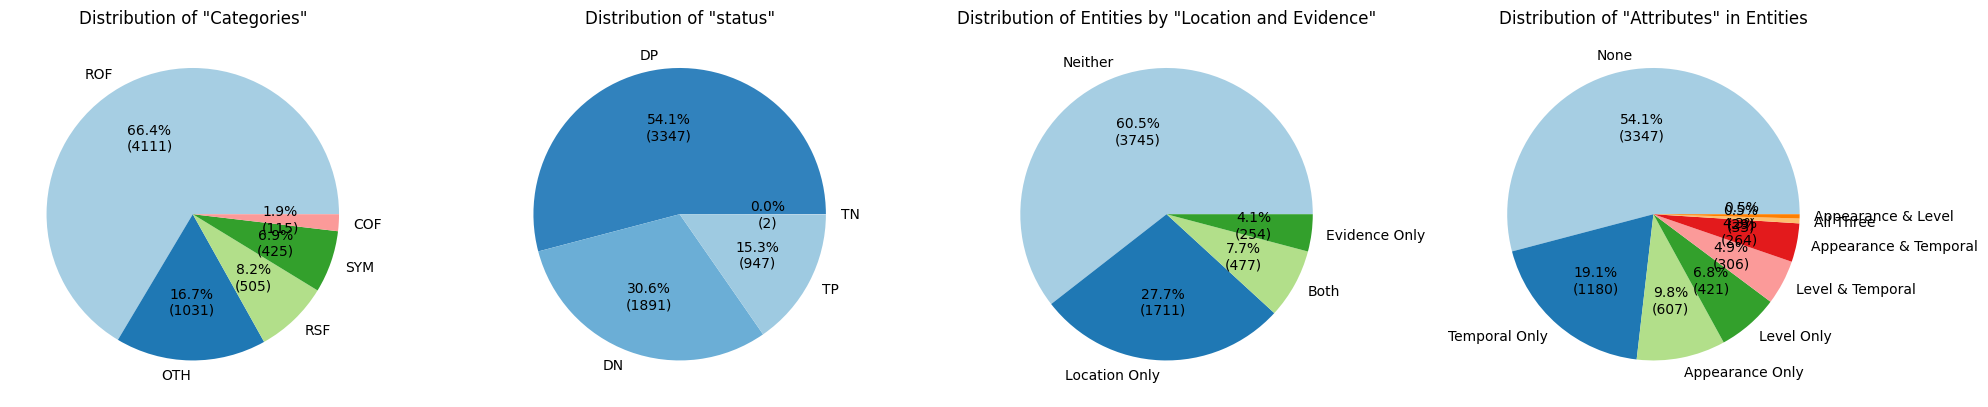

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure and three subplots (1 row x 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# First plot: Category ratios
cat_counts = final_patient_data['cat'].value_counts()
axes[0].pie(cat_counts, labels=cat_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(cat_counts) / 100), colors=plt.cm.Paired(np.arange(len(cat_counts))))
axes[0].set_title('Distribution of "Categories"')
axes[0].set_ylabel('')  # Remove y-axis label for clarity

status_prefix_counts = final_patient_data['status_prefix'].value_counts()

axes[1].pie(status_prefix_counts, labels=status_prefix_counts.index, 
        autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(status_prefix_counts) / 100), 
        colors=plt.cm.tab20c(np.arange(len(status_prefix_counts))))


axes[1].set_title('Distribution of "status"')

# Second plot: Distribution by Location and Evidence
conditions = [
    (final_patient_data['location'].notna() & final_patient_data['evidence'].notna()),
    (final_patient_data['location'].notna() & final_patient_data['evidence'].isna()),
    (final_patient_data['location'].isna() & final_patient_data['evidence'].notna()),
    (final_patient_data['location'].isna() & final_patient_data['evidence'].isna())
]
choices = ['Both', 'Location Only', 'Evidence Only', 'Neither']
final_patient_data['status'] = np.select(conditions, choices, default='Neither')
status_counts = final_patient_data['status'].value_counts()
axes[2].pie(status_counts, labels=status_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(status_counts) / 100), colors=plt.cm.Paired(np.arange(len(status_counts))))
axes[2].set_title('Distribution of Entities by "Location and Evidence"')

# Third plot: Distribution of Attributes
final_patient_data['appearance'] = final_patient_data[['morphology', 'distribution', 'size']].notna().any(axis=1)
final_patient_data['level'] = final_patient_data[['num', 'severity', 'comparision']].notna().any(axis=1)  # Correction on 'comparison'
final_patient_data['temporal'] = final_patient_data[['emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve']].notna().any(axis=1)
conditions = [
    (final_patient_data['appearance'] & final_patient_data['level'] & final_patient_data['temporal']),
    (final_patient_data['appearance'] & final_patient_data['level'] & ~final_patient_data['temporal']),
    (final_patient_data['appearance'] & ~final_patient_data['level'] & final_patient_data['temporal']),
    (~final_patient_data['appearance'] & final_patient_data['level'] & final_patient_data['temporal']),
    (final_patient_data['appearance'] & ~final_patient_data['level'] & ~final_patient_data['temporal']),
    (~final_patient_data['appearance'] & final_patient_data['level'] & ~final_patient_data['temporal']),
    (~final_patient_data['appearance'] & ~final_patient_data['level'] & final_patient_data['temporal']),
    (~final_patient_data['appearance'] & ~final_patient_data['level'] & ~final_patient_data['temporal'])
]
choices = [
    'All Three', 'Appearance & Level', 'Appearance & Temporal', 'Level & Temporal',
    'Appearance Only', 'Level Only', 'Temporal Only', 'None'
]
final_patient_data['attribute_status'] = np.select(conditions, choices, default='None')
attribute_counts = final_patient_data['attribute_status'].value_counts()
axes[3].pie(attribute_counts, labels=attribute_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(attribute_counts) / 100), colors=plt.cm.Paired(np.arange(len(attribute_counts))))
axes[3].set_title('Distribution of "Attributes" in Entities')

# Display the figure
plt.tight_layout()
plt.show()


## 케이스 5. status 구분. 
    1. DP, DN만 존재하는 경우
        => 영상내 모든 시퀀스에서 확실한 진단이 내려진 상황

    2. 해당 질병 판단에서 환자중 TP와 TN이 많은 케이스는?  
        1. ROF TPTN top 10 (=> evidence가 약한 상황?)

        2. RSF가 TPTN top 10 환자. (context로 보아 거의 맞지

    3. sequence에 따라 특정 entity에 대한 변화가 많은 케이스.
        => 환자의 여러 시퀀스에 걸쳐 특정 entity에 대한 관찰된 내용이 많은 케이스.
            1. 변화가 많은 케이스.
                1. 심각한 변화. DP -> DN / DN -> DP
                2. 점진적 변화. TP -> DP / TN -> DN
                ex. pneumonia -> TP, TP, DP, DN 
            2. 변화는 없지만 언급된 케이스.
            3. 간헐적 mention이 있는 케이스.
                (1번 이상 특정 entity에 대한 내용없이 뜨문 뜨문 멘션이 있는 경우)

### 모든 section, 모든 category에 대해 
### (DP, DN) vs (DP, DN, TP, TN) vs (TP, TN)
### TP, TN만 적혀 있는 리포프는 전체 딱 1건

In [127]:
# Group data by patient and aggregate status_prefix into lists
status_by_study = df_final_filtered.groupby('study_id')['status_prefix'].agg(list)
status_by_patient = df_final_filtered.groupby('patient_id')['status_prefix'].agg(list)

# Define categories
categories = {
    'patient_only_tp_tn': 0,
    'patient_both': 0,
    'patient_only_dp_dn': 0,
    'study_only_tp_tn': 0,
    'study_both': 0,
    'study_only_dp_dn': 0,
    'else':0
}
patinet_tp_tn_list = []
# Analyze each patient
for patient_id, statuses_patient in status_by_patient.items():    
    has_tp_tn_patient = any(status in ['TP', 'TN'] for status in statuses_patient)
    has_dp_dn_patient = any(status in ['DP', 'DN'] for status in statuses_patient)
        
    if has_tp_tn_patient and not has_dp_dn_patient:
        categories['patient_only_tp_tn'] += 1
        patinet_tp_tn_list.append(patient_id)
        
    elif has_tp_tn_patient and has_dp_dn_patient:
        categories['patient_both'] += 1
    elif not has_tp_tn_patient and has_dp_dn_patient:
        categories['patient_only_dp_dn'] += 1

print("patient_only_tp_tn", patinet_tp_tn_list)

tp_tn_list = []        
for study_id, statuses_study in status_by_study.items():    
    has_tp_tn_std = any(status in ['TP', 'TN'] for status in statuses_study)
    has_dp_dn_std = any(status in ['DP', 'DN'] for status in statuses_study)
    
    if has_tp_tn_std and not has_dp_dn_std:
        categories['study_only_tp_tn'] += 1
        tp_tn_list.append(study_id)
        
        # print("categories['study_only_tp_tn']", categories['study_only_tp_tn'])
    elif has_tp_tn_std and has_dp_dn_std:
        categories['study_both'] += 1
        # print("categories['study_both']", categories['study_both'])
    elif not has_tp_tn_std and has_dp_dn_std:
        categories['study_only_dp_dn'] += 1

        
# Display the results
total_patients = len(status_by_patient)
total_studies = len(status_by_study)
print(f"Patients with only 'TP', 'TN': {categories['patient_only_tp_tn']}, {(categories['patient_only_tp_tn'] / total_patients):.2f}%")
print(f"Patients with both 'TP', 'TN' and 'DP', 'DN': {categories['patient_both']}, {(categories['patient_both'] / total_patients):.2f}%")
print(f"Patients with only 'DP', 'DN': {categories['patient_only_dp_dn']}, {(categories['patient_only_dp_dn'] / total_patients):.2f}%")

print("\n")
print("study_only_tp_tn", tp_tn_list)

print(f"Studies with only 'TP', 'TN': {categories['study_only_tp_tn']}, {(categories['study_only_tp_tn'] / total_studies):.2f}%")
print(f"Studies with both 'TP', 'TN' and 'DP', 'DN': {categories['study_both']}, {(categories['study_both'] / total_studies):.2f}%")
print(f"Studies with only 'DP', 'DN': {categories['study_only_dp_dn']}, {(categories['study_only_dp_dn'] / total_studies):.2f}%")

# # Filter out rows where sec is 'HIST' and cat is either 'SYM' or 'COF'
# filtered_df = df_final_filtered[
#     (df_final_filtered['sec'] != 'HIST') & 
#     (~df_final_filtered['cat'].isin(['SYM', 'COF']))
# ]

# # Group the filtered data by patient and aggregate status_prefix into lists
# status_by_study = filtered_df.groupby('study_id')['status_prefix'].agg(list)
# status_by_patient = filtered_df.groupby('patient_id')['status_prefix'].agg(list)

# # Define categories
# categories = {
#     'patient_only_tp_tn': 0,
#     'patient_both': 0,
#     'patient_only_dp_dn': 0,
#     'study_only_tp_tn': 0,
#     'study_both': 0,
#     'study_only_dp_dn': 0
# }
# patinet_tp_tn_list = []
# # Analyze each patient
# for patient_id, statuses_patient in status_by_patient.items():    
#     has_tp_tn_patient = any(status in ['TP', 'TN'] for status in statuses_patient)
#     has_dp_dn_patient = any(status in ['DP', 'DN'] for status in statuses_patient)
        
#     if has_tp_tn_patient and not has_dp_dn_patient:
#         categories['patient_only_tp_tn'] += 1
#         patinet_tp_tn_list.append(patient_id)
#     elif has_tp_tn_patient and has_dp_dn_patient:
#         categories['patient_both'] += 1
#     elif not has_tp_tn_patient and has_dp_dn_patient:
#         categories['patient_only_dp_dn'] += 1


# tp_tn_list = []
# for study_id, statuses_study in status_by_study.items():    
#     has_tp_tn_std = any(status in ['TP', 'TN'] for status in statuses_study)
#     has_dp_dn_std = any(status in ['DP', 'DN'] for status in statuses_study)
    
#     if has_tp_tn_std and not has_dp_dn_std:
#         categories['study_only_tp_tn'] += 1
#         tp_tn_list.append(study_id)
        
#         # print("categories['study_only_tp_tn']", categories['study_only_tp_tn'])
#     elif has_tp_tn_std and has_dp_dn_std:
#         categories['study_both'] += 1
#         # print("categories['study_both']", categories['study_both'])
#     elif not has_tp_tn_std and has_dp_dn_std:
#         categories['study_only_dp_dn'] += 1

                    
# Display the results
# print("-------------------")
# print("## History section 제외, 'COF', 'SYM' cateogry 제외.")
# total_patients = len(status_by_patient)
# total_studies = len(status_by_study)
# print(f"Patients with only 'TP', 'TN': {categories['patient_only_tp_tn']}, {(categories['patient_only_tp_tn'] / total_patients):.2f}%")
# print(f"Patients with both 'TP', 'TN' and 'DP', 'DN': {categories['patient_both']}, {(categories['patient_both'] / total_patients):.2f}%")
# print(f"Patients with only 'DP', 'DN': {categories['patient_only_dp_dn']}, {(categories['patient_only_dp_dn'] / total_patients):.2f}%")

# print("\n")
# print(f"Studies with only 'TP', 'TN': {categories['study_only_tp_tn']}, {(categories['study_only_tp_tn'] / total_studies):.2f}%")
# print(f"Studies with both 'TP', 'TN' and 'DP', 'DN': {categories['study_both']}, {(categories['study_both'] / total_studies):.2f}%")
# print(f"Studies with only 'DP', 'DN': {categories['study_only_dp_dn']}, {(categories['study_only_dp_dn'] / total_studies):.2f}%")
# print("patient_only_tp_tn", patinet_tp_tn_list)
# print("study_only_tp_tn", tp_tn_list)


patient_only_tp_tn []
Patients with only 'TP', 'TN': 0, 0.00%
Patients with both 'TP', 'TN' and 'DP', 'DN': 285, 0.97%
Patients with only 'DP', 'DN': 8, 0.03%


study_only_tp_tn ['s59799399']
Studies with only 'TP', 'TN': 1, 0.00%
Studies with both 'TP', 'TN' and 'DP', 'DN': 2165, 0.66%
Studies with only 'DP', 'DN': 1103, 0.34%


In [128]:
df_final_filtered[df_final_filtered['study_id'] == 's59799399'][['ent', 'cat','sec','sequence', 'status_prefix']]#.drop_duplicates(['report'])#['status_prefix'].values

,ent,cat,sec,sequence,status_prefix
36161,Indwelling support and monitoring devices,OTH,FIND,3,TN
36162,cardiomegaly,ROF,FIND,3,TN
36163,pulmonary vascular congestion,ROF,FIND,3,TP
36164,aeration,ROF,FIND,3,TP
36165,atelectasis,ROF,FIND,3,TP
36166,pleural effusions,ROF,FIND,3,TP
36167,extension into the right minor fissure,ROF,FIND,3,TP


### sub case 1. 환자중 DP와 DN이 많은 케이스는?  
의미: DP, DN의 관찰 갯수가 많다는건 특정 환자에서 여러 시퀀스에 따라 
그냥 누적해서 뽑으면, 항상 긴 시퀀스만 담기기 때문에 골고루 안뽑힘.
=> 여러 시퀀스 골고루 뽑히기 위해 시퀀스당 각 category DP/ 전체 cat

### 분석 목적: 
    DP 인 경우, (DP, DN의 경우가 전체 시퀀스 대비 몇 %인가 표시) => 
    1. 어떤 카테고리에 대해 DP/DN이 많은가?
     => 카테고리별 DP, DN이 많은 순으로 샘플링.

    1. ROF DPDN top 10 (=> evidence는 충분한가?)
        - 시퀀스에 따라 점점 줄어든다면, evidence가 뒷받침되어 DP, DN으로 넘어가는 상황?
        - 시퀀스에 따라 점점 늘게된면, 없던게 점점 생기는 상황?

    2. RSF가 DPDN top 10 환자. (context로 보아 거의 맞지만 cxr이니 불확실?)
        - 가장 첫번째 스터디에서 RSF가 확신이라면, 왜 때문인가?
        - 시퀀스에 따라 점점 줄어든다면, 해결?
        - 시퀀스에 따라 점점 늘게된면, 확신 없던게 점점 생기는 상황? (TP -> DP?)

방법:
1. 환자별로 OTH, ROF, RSF에 대해 시퀀스별 mention의 갯수를 측정
2. 각 시퀀스에서 (해당 cateogry DP,DN / 전체 ent cateogry 갯수) 시퀀스당 ratio 찍어서, 
3. 여러 시퀀스의 평균을 보고 환자 샘플링 top-k 명

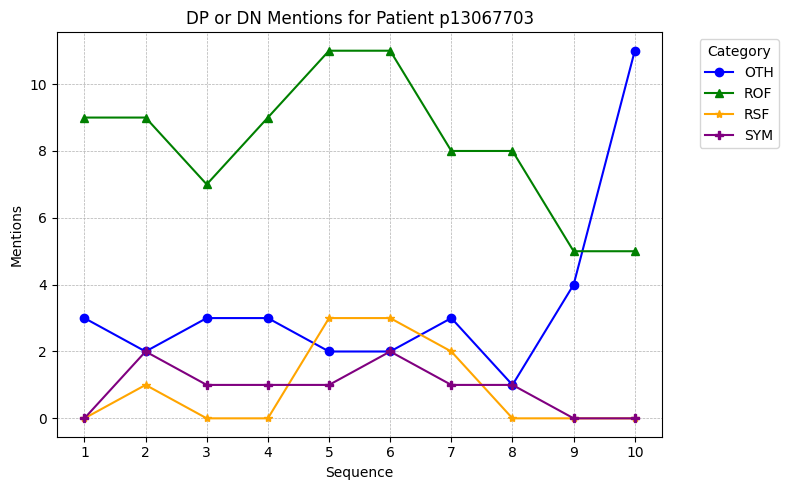

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category colors and markers
category_colors = {
    'OTH': 'blue',
    'ROF': 'green',
    'COF': 'red',
    'SYM': 'purple',
    'RSF': 'orange'
}

category_markers = {
    'OTH': 'o',  # Circle
    'ROF': '^',  # Triangle up
    'COF': 's',  # Square
    'SYM': 'P',  # Plus (filled)
    'RSF': '*'   # Star
}

# Filter data for patients with sequences between 5 and 9
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient <= 10)].index

# Step 1: Count 'TN' and 'TP' mentions for each patient
mention_counts = df_final_filtered[df_final_filtered['status_prefix'].isin(['DN', 'DP']) &
                                   df_final_filtered['patient_id'].isin(patients_with_2_to_10_sequences)
                                  ].groupby('patient_id').size()

# Step 2: Rank patients by their mention counts and select the top 10
top_10_patients = mention_counts.nlargest(3).index

# Step 3: Iterate over these top 10 patients to generate plots
for patient_id in top_10_patients:
    patient_data = df_final_filtered[(df_final_filtered['patient_id'] == patient_id) & 
                                      (df_final_filtered['status_prefix'].isin(['DN', 'DP']))]
    
    # Group by sequence and category to count these specific mentions
    mentions_per_sequence = patient_data.groupby(['sequence', 'cat']).size().reset_index(name='mentions')
    
    # Pivot this data for plotting
    pivot_data = mentions_per_sequence.pivot(index='sequence', columns='cat', values='mentions').fillna(0)
    
    plt.figure(figsize=(8, 5))
    for category in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[category], label=category,
                 color=category_colors.get(category, 'black'),
                 marker=category_markers.get(category, 'o'))  # Default marker if not found

    plt.title(f'DP or DN Mentions for Patient {patient_id}')
    plt.xlabel('Sequence')
    plt.ylabel('Mentions')
    plt.xticks(pivot_data.index)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    break


### sub case 2. 환자중 TP와 TN이 많은 케이스는?  (DP, DN과 동일한 방법으로 진행)

### 분석 목적: 
    1. ROF TPTN top 10 (=> evidence가 약한 상황?)
        - 시퀀스에 따라 점점 줄어든다면, evidence가 뒷받침되어 DP, DN으로 넘어가는 상황?
        - 시퀀스에 따라 점점 늘게된면, 없던게 점점 생기는 상황?

    2. RSF가 TPTN top 10 환자. (context로 보아 거의 맞지만 cxr이니 불확실?)
        - 시퀀스에 따라 점점 줄어든다면, evidence가 뒷받침되어 DP, DN으로 넘어가는 상황?
        - 시퀀스에 따라 점점 늘게된면, 없던게 점점 생기는 상황?

방법:
1. 환자별로 ROF, RSF에 대해 시퀀스별 mention의 갯수를 측정
2. 여러 시퀀스에 걸쳐 ROF, RSF가 보통은 줄텐데, 늘어난 경우는?
3. 여러 시퀀스에 걸쳐 ROF, RSF가 보통은 줄텐데, 줄었어도 여전히 많은 경우는 (전체 시퀀스에서 누적 ROF, RSF TPTN의 갯수)?
4. 이러한 케이스 파악을 마친 후, 환자 선별.

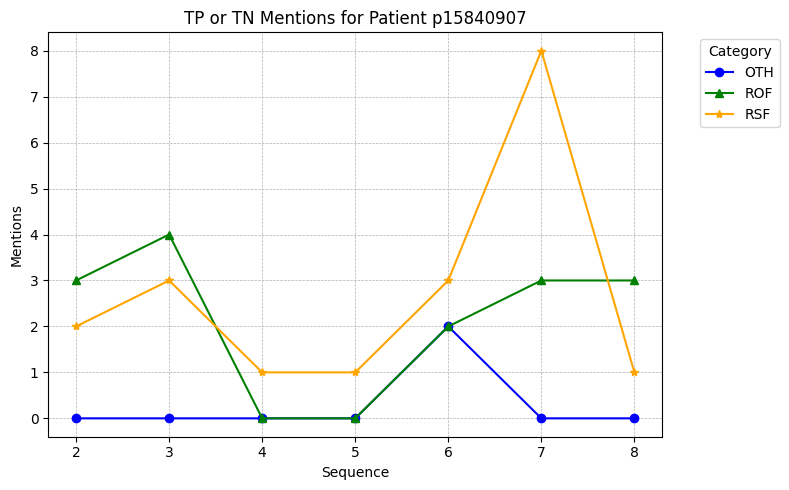

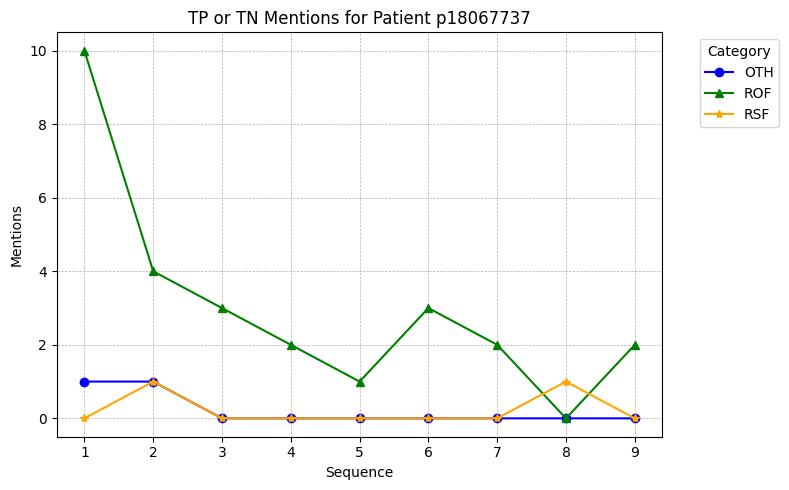

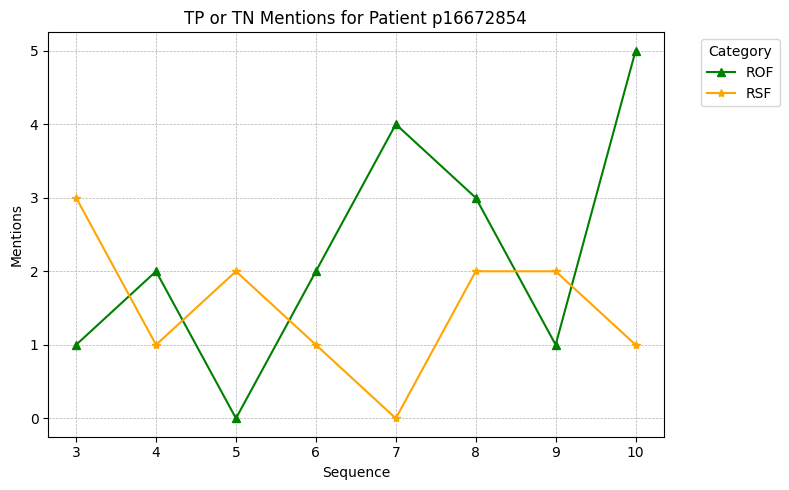

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category colors and markers
category_colors = {
    'OTH': 'blue',
    'ROF': 'green',
    'COF': 'red',
    'SYM': 'purple',
    'RSF': 'orange'
}

category_markers = {
    'OTH': 'o',  # Circle
    'ROF': '^',  # Triangle up
    'COF': 's',  # Square
    'SYM': 'P',  # Plus (filled)
    'RSF': '*'   # Star
}

# Filter data for patients with sequences between 5 and 9
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient <= 10)].index

# Step 1: Count 'TN' and 'TP' mentions for each patient
mention_counts = df_final_filtered[df_final_filtered['status_prefix'].isin(['TN', 'TP']) &
                                   df_final_filtered['patient_id'].isin(patients_with_2_to_10_sequences)
                                  ].groupby('patient_id').size()

# Step 2: Rank patients by their mention counts and select the top 10
top_10_patients = mention_counts.nlargest(3).index

# Step 3: Iterate over these top 10 patients to generate plots
for patient_id in top_10_patients:
    patient_data = df_final_filtered[(df_final_filtered['patient_id'] == patient_id) & 
                                      (df_final_filtered['status_prefix'].isin(['TN', 'TP']))]
    
    # Group by sequence and category to count these specific mentions
    mentions_per_sequence = patient_data.groupby(['sequence', 'cat']).size().reset_index(name='mentions')
    
    # Pivot this data for plotting
    pivot_data = mentions_per_sequence.pivot(index='sequence', columns='cat', values='mentions').fillna(0)
    
    plt.figure(figsize=(8, 5))
    for category in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[category], label=category,
                 color=category_colors.get(category, 'black'),
                 marker=category_markers.get(category, 'o'))  # Default marker if not found

    plt.title(f'TP or TN Mentions for Patient {patient_id}')
    plt.xlabel('Sequence')
    plt.ylabel('Mentions')
    plt.xticks(pivot_data.index)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## 3. sequence에 따라 특정 entity에 대한 변화가 많은 케이스.
    => 환자의 여러 시퀀스에 걸쳐 특정 entity에 대한 관찰된 내용이 많은 케이스.
        1. 변화가 많은 케이스.
            1. 심각한 변화. DP -> DN / DN -> DP
            2. 점진적 변화. TP -> DP / TN -> DN
            ex. pneumonia -> TP, TP, DP, DN 
        2. 변화는 없지만 언급된 케이스.
        3. 간헐적 mention이 있는 케이스.
            (1번 이상 특정 entity에 대한 내용없이 뜨문 뜨문 멘션이 있는 경우)

변화의 트렌드를 분석한다는건.

1. 각각 어디서 어떻게 변화하는지를 전체데 대해 분석하고
    ex. DP -> DN, DP -> TP, DP -> DN 

각각의 위와 같은 상황에서 평균 behavior를 관찰한 후에, variance를 보고 평균과 variance, 즉 outlier까지 같이 담아야 하는거

증감률

1. 확신의 비율이 어떻게 변화하는가? 
    각 시퀀스별 (각 카테고리 (DP, DN), (TP, TN) 갯수/전체 entity) 비율을 나타내고 이를 기반으로 증가하는지 감소하는지

2. positive, negative의 비율이 어떻게 변화하는가?
    각 시퀀스별 (각 카테고리 (DP, TP), (DN, TN) 갯수/전체 entity) 비율을 나타내고 이를 기반으로 증가하는지 감소하는지


분석 이유:
1. 데이터의 이해를 위해 필요한데, 
    1. 점점 확실해지는게 일반적일텐데 2. 불확실해지는 환자 샘플링
2. 
    1. 점점 문제가 생기는 환자 2. 점점 괜찮아지는 환자.

3. 시퀀스별 증감률 폭이 크다는 의미는 특정 시퀀스에서 다음 시퀀스로 넘어갈때, 변화 폭이 크다는 의미.

4. 분모의 갯수 차이가 심하다는 의미는 리포트에 적힌 내용이 별로 없어서 absent가 많다는 의미. => 시퀀셜 데이터가 채워줘야할 부분.

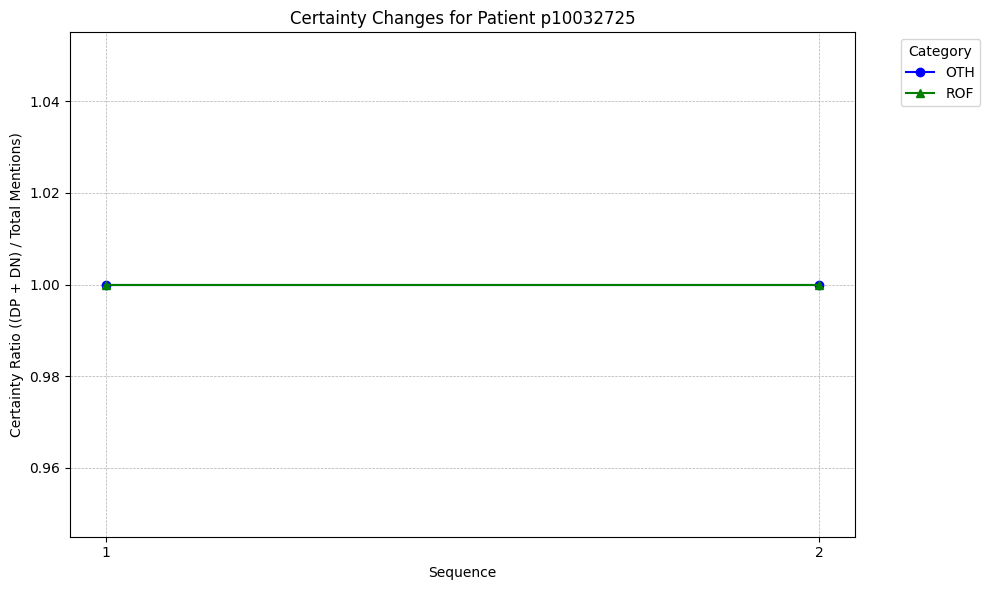

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category colors and markers
category_colors = {
    'OTH': 'blue',
    'ROF': 'green',
    'COF': 'red',
    'SYM': 'purple',
    'RSF': 'orange'
}

category_markers = {
    'OTH': 'o',  # Circle
    'ROF': '^',  # Triangle up
    'COF': 's',  # Square
    'SYM': 'P',  # Plus (filled)
    'RSF': '*'   # Star
}

# Filter data for patients with sequences between 5 and 9
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient <= 10)].index

# Iterate over these patients to generate plots
for patient_id in patients_with_2_to_10_sequences:
    patient_data = df_final_filtered[df_final_filtered['patient_id'] == patient_id]

    # Calculate DP + DN mentions per sequence
    dp_dn_counts = patient_data[patient_data['status_prefix'].isin(['DP', 'DN'])].groupby(['sequence', 'cat']).size().unstack(fill_value=0)
    total_mentions = patient_data.groupby(['sequence', 'cat']).size().unstack(fill_value=0)

    # Calculate certainty ratio: (DP + DN) / total mentions
    certainty_ratio = dp_dn_counts / total_mentions

    # Plotting the certainty ratio across sequences for each category
    plt.figure(figsize=(10, 6))
    for category in certainty_ratio.columns:
        if category in category_colors:  # Ensure category is one of the predefined
            plt.plot(certainty_ratio.index, certainty_ratio[category], label=category, color=category_colors[category], marker=category_markers[category])

    plt.title(f'Certainty Changes for Patient {patient_id}')
    plt.xlabel('Sequence')
    plt.ylabel('Certainty Ratio ((DP + DN) / Total Mentions)')
    plt.xticks(certainty_ratio.index)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    break


/tmp/ipykernel_2569828/2595037047.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  certainty_data = pd.DataFrame(index=index, columns=['Certainty']).fillna(0)


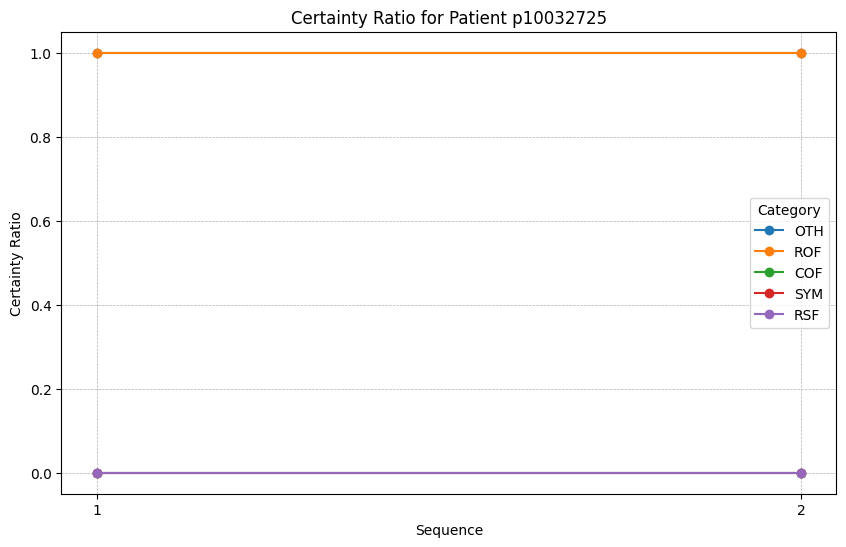

/tmp/ipykernel_2569828/2595037047.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  certainty_data = pd.DataFrame(index=index, columns=['Certainty']).fillna(0)
/tmp/ipykernel_2569828/2595037047.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  certainty_data.at[(sequence, category), 'Certainty'] = certainty_ratio


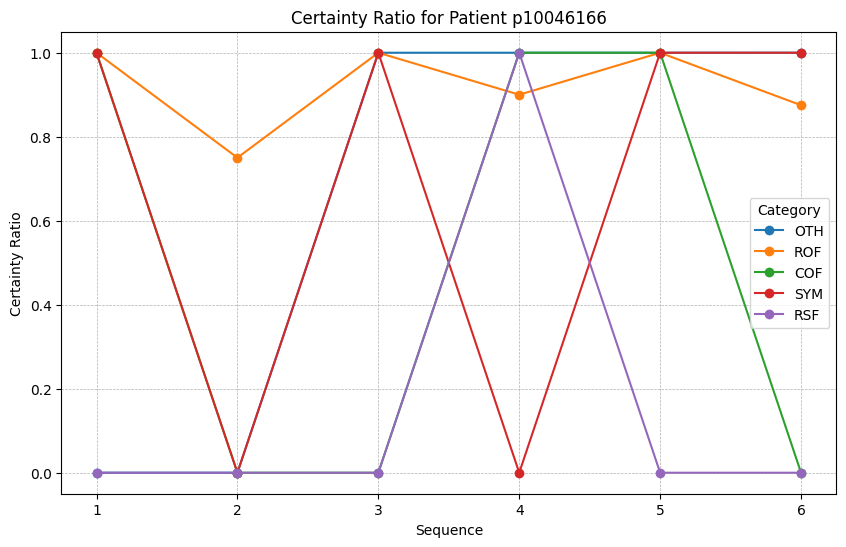

/tmp/ipykernel_2569828/2595037047.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  certainty_data = pd.DataFrame(index=index, columns=['Certainty']).fillna(0)
/tmp/ipykernel_2569828/2595037047.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  certainty_data.at[(sequence, category), 'Certainty'] = certainty_ratio


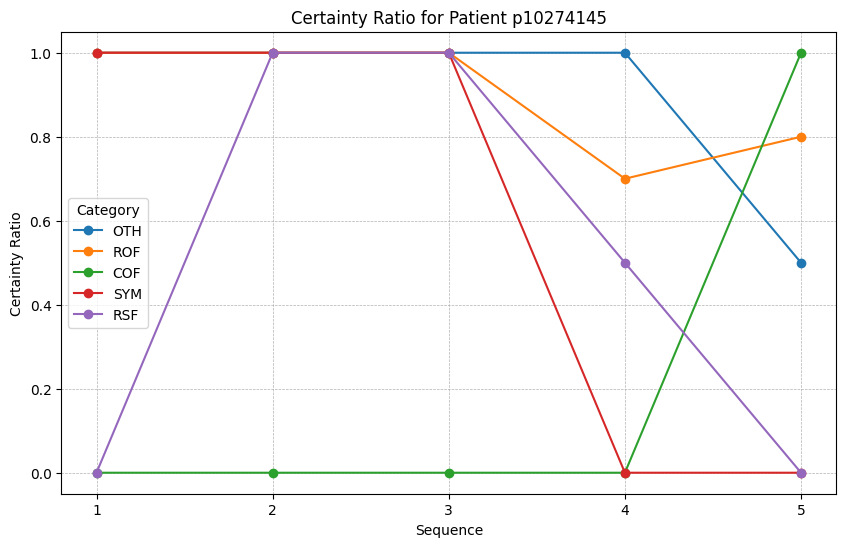

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category colors and markers
category_colors = {
    'OTH': 'blue',
    'ROF': 'green',
    'COF': 'red',
    'SYM': 'purple',
    'RSF': 'orange'
}

category_markers = {
    'OTH': 'o',  # Circle
    'ROF': '^',  # Triangle up
    'COF': 's',  # Square
    'SYM': 'P',  # Plus (filled)
    'RSF': '*'   # Star
}

# Filter patients within the desired sequence range
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient <= 10)].index

# Prepare data for each patient
# Define the categories
categories = ['OTH', 'ROF', 'COF', 'SYM', 'RSF']

# Prepare to plot for each patient
for itr, patient_id in enumerate(patients_with_2_to_10_sequences):
    
    if itr< 3:
        patient_data = df_final_filtered[df_final_filtered['patient_id'] == patient_id]
        unique_sequences = patient_data['sequence'].unique()

        # Create a DataFrame indexed by sequence and category
        index = pd.MultiIndex.from_product([unique_sequences, categories], names=['sequence', 'cat'])
        certainty_data = pd.DataFrame(index=index, columns=['Certainty']).fillna(0)

        # Calculate certainty values
        for sequence in unique_sequences:
            sequence_data = patient_data[patient_data['sequence'] == sequence]
            for category in categories:
                category_data = sequence_data[sequence_data['cat'] == category]
                dp_dn_count = category_data[category_data['status_prefix'].isin(['DP', 'DN'])].shape[0]
                total_count = category_data.shape[0]
                certainty_ratio = dp_dn_count / total_count if total_count > 0 else 0
                certainty_data.at[(sequence, category), 'Certainty'] = certainty_ratio

        # Pivot for plotting
        plot_data = certainty_data.unstack('cat')['Certainty']
        
        plt.figure(figsize=(10, 6))
        for category in categories:
            plt.plot(plot_data.index, plot_data[category], label=category, marker='o')

        plt.title(f'Certainty Ratio for Patient {patient_id}')
        plt.xlabel('Sequence')
        plt.ylabel('Certainty Ratio')
        plt.xticks(plot_data.index)
        plt.legend(title='Category')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()
    else: break


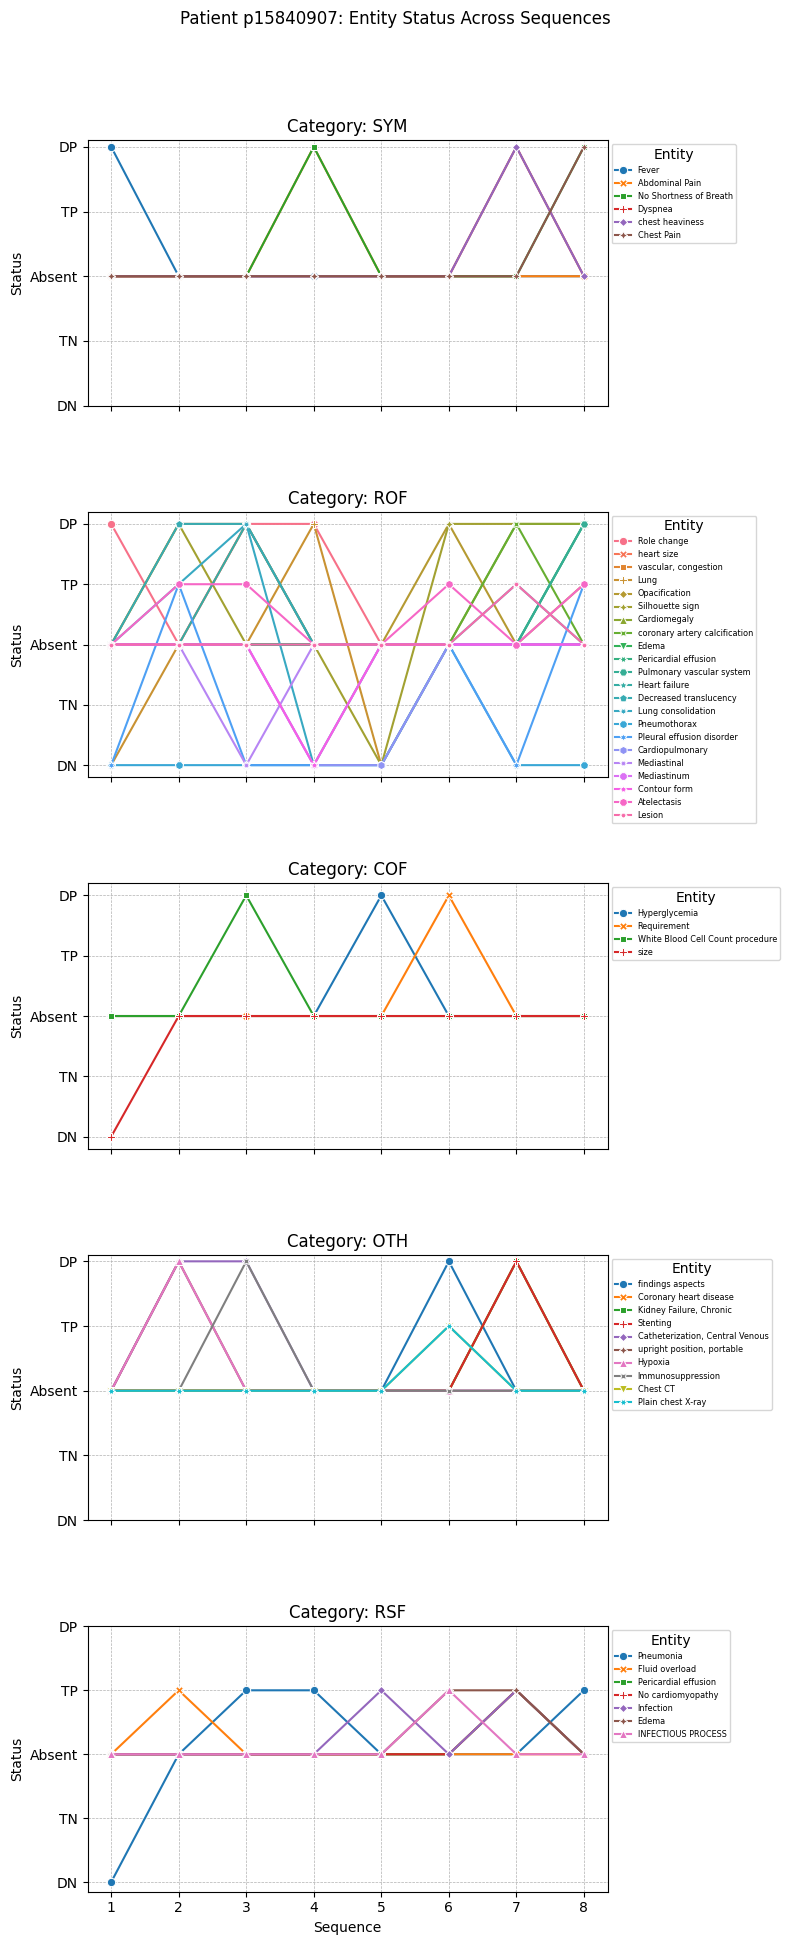

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties

# Assuming 'df_final_filtered' is your initial DataFrame
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
# patients_with_5_or_more_sequences = sequences_per_patient[sequences_per_patient >= 5].index

status_to_numeric_updated = {'DP': 1, 'TP': 0.5, 'TN': -0.5, 'DN': -1, 'Absent': 0}

patients_with_2_to_10_sequences = sequences_per_patient[(sequences_per_patient >= 2) & (sequences_per_patient <= 10)].index

# Step 1: Count 'TN' and 'TP' mentions for each patient
mention_counts = df_final_filtered[df_final_filtered['status_prefix'].isin(['TN', 'TP']) &
                                   df_final_filtered['patient_id'].isin(patients_with_2_to_10_sequences)
                                  ].groupby('patient_id').size()

# Step 2: Rank patients by their mention counts and select the top 10
top_10_patients = mention_counts.nlargest(3).index

# Step 3: Iterate over these top 10 patients to generate plots
for patient_id in top_10_patients:
    patient_data = df_final_filtered[df_final_filtered['patient_id'] == patient_id]

    sequence_summary = patient_data.groupby(['sequence', 'ontology_norm', 'cat', 'status_prefix']).size().reset_index(name='count')
    sequence_summary['NumericStatus'] = sequence_summary['status_prefix'].map(status_to_numeric_updated)
    
    priority_map = {'DP': 4, 'TP': 2, 'Absent': 0, 'TN': 1, 'DN': 3}
    sequence_summary['priority'] = sequence_summary['status_prefix'].map(priority_map)

    sequence_summary = sequence_summary.sort_values('priority', ascending=False).drop_duplicates(['sequence', 'ontology_norm'], keep='first')

    all_sequences = range(1, patient_data['sequence'].max() + 1)
    entity_category_pairs = sequence_summary[['ontology_norm', 'cat']].drop_duplicates()

    all_combinations = pd.DataFrame([
        (seq, ontology_norm, cat) for seq in all_sequences for ontology_norm, cat in entity_category_pairs.itertuples(index=False, name=None)
    ], columns=['sequence', 'ontology_norm', 'cat'])

    full_data_filtered = all_combinations.merge(sequence_summary, on=['sequence', 'ontology_norm', 'cat'], how='left').fillna({'NumericStatus': status_to_numeric_updated['Absent'], 'status_prefix': 'Absent'})

    categories = full_data_filtered['cat'].unique()
    num_categories = len(categories)
    fig, axs = plt.subplots(num_categories, 1, figsize=(8, 4*num_categories), sharex=True)
    
    if num_categories == 1:
        axs = [axs]
    
    legend_font_props = FontProperties(size='small')  # Use 'small' as a baseline
    scaled_font_size = legend_font_props.get_size_in_points() * 0.7  # Scale the font size to 70%
    
    for ax, category in zip(axs, categories):
        category_data = full_data_filtered[full_data_filtered['cat'] == category]
        sns.lineplot(data=category_data, x='sequence', y='NumericStatus', hue='ontology_norm', style='ontology_norm', markers=True, dashes=False, ax=ax)
        ax.set_title(f'Category: {category}')
        ax.set_xlabel('Sequence')
        ax.set_ylabel('Status')
        ax.set_xticks(list(all_sequences))
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticklabels(['DN', 'TN', 'Absent', 'TP', 'DP'])
        ax.grid(True, linestyle='--', linewidth=0.5)
        # Adjust legend with scaled font size
        ax.legend(title='Entity', bbox_to_anchor=(1, 1), loc='upper left', prop=FontProperties(size=scaled_font_size))

    plt.suptitle(f'Patient {patient_id}: Entity Status Across Sequences')
    plt.tight_layout(rect=[0, 0.01, 1, 0.95])
    plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing between plots
    plt.show()
    break


# 최종 5 case로부터 환자 xx명, 스터디 xx개 종합.
## chronologically 구성한 내용까지 한번에 제공 

### 리뷰.
1. 싱글 레벨에서 리뷰
2. 최종, 리뷰한 내용을 기반으로 마지막장에 chronologically 재평가한 결과 첨부.
    a. gpt4 기반으로 entity별 tracking.
    

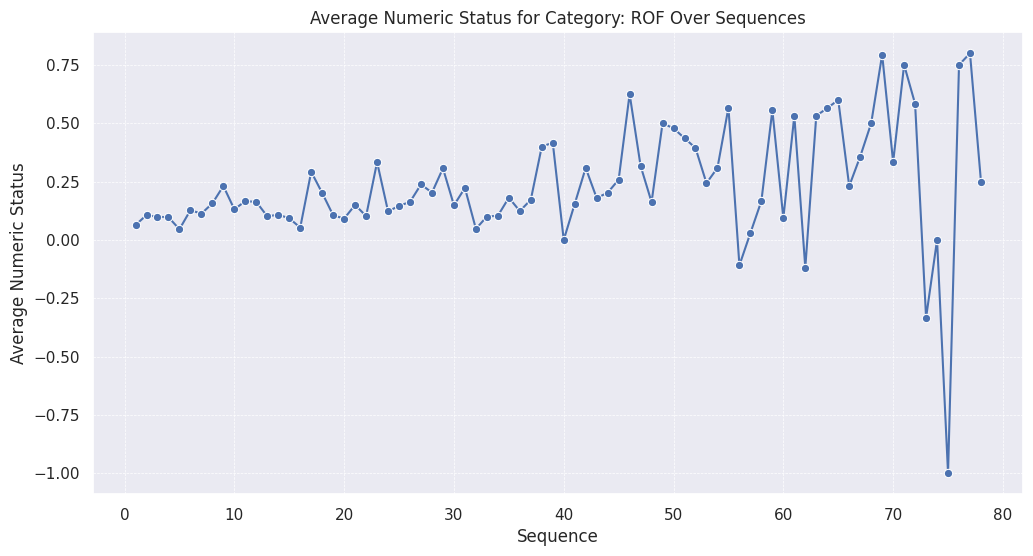

In [29]:
# Calculate the average status or count for each sequence-category combination

df_rof = df_final_filtered[df_final_filtered['cat'] == 'ROF']

# Calculate the average status per sequence for the "ROF" category
average_status_rof = df_rof.groupby('sequence')['NumericStatus'].mean().reset_index()

# sequence_category_status = df_final_filtered.groupby(['sequence', 'cat', 'status_prefix']).size().reset_index(name='count')

# # Alternatively, to get the average numeric status across patients for a more granular view:
# df_final_filtered['NumericStatus'] = df_final_filtered['status_prefix'].map(status_to_numeric_updated)
# average_status = df_final_filtered.groupby(['sequence', 'cat'])['NumericStatus'].mean().reset_index()

import seaborn as sns; sns.set_theme()

# status_pivot = average_status.pivot(index='cat', columns='sequence', values='NumericStatus')

# status_pivot = average_status_rof.pivot(index='sequence', columns='sequence', values='NumericStatus')
# Assuming average_status_rof contains 'sequence' and 'NumericStatus' for the 'ROF' category

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_status_rof, x='sequence', y='NumericStatus', marker='o', linestyle='-')
plt.title('Average Numeric Status for Category: ROF Over Sequences')
plt.xlabel('Sequence')
plt.ylabel('Average Numeric Status')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


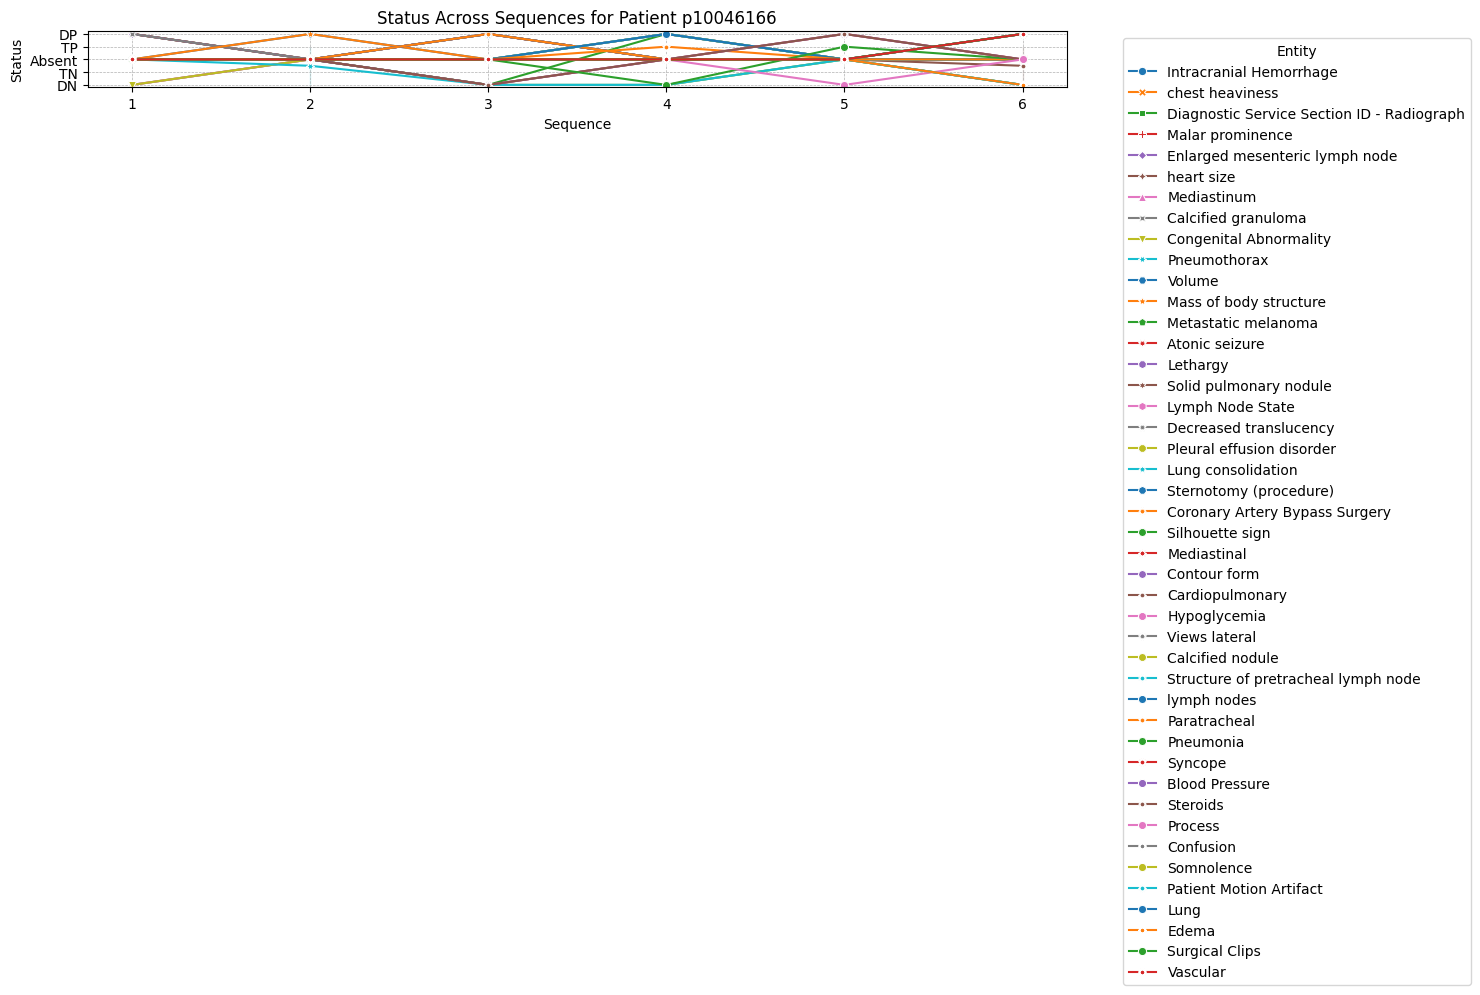

/tmp/ipykernel_3605734/4036454139.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


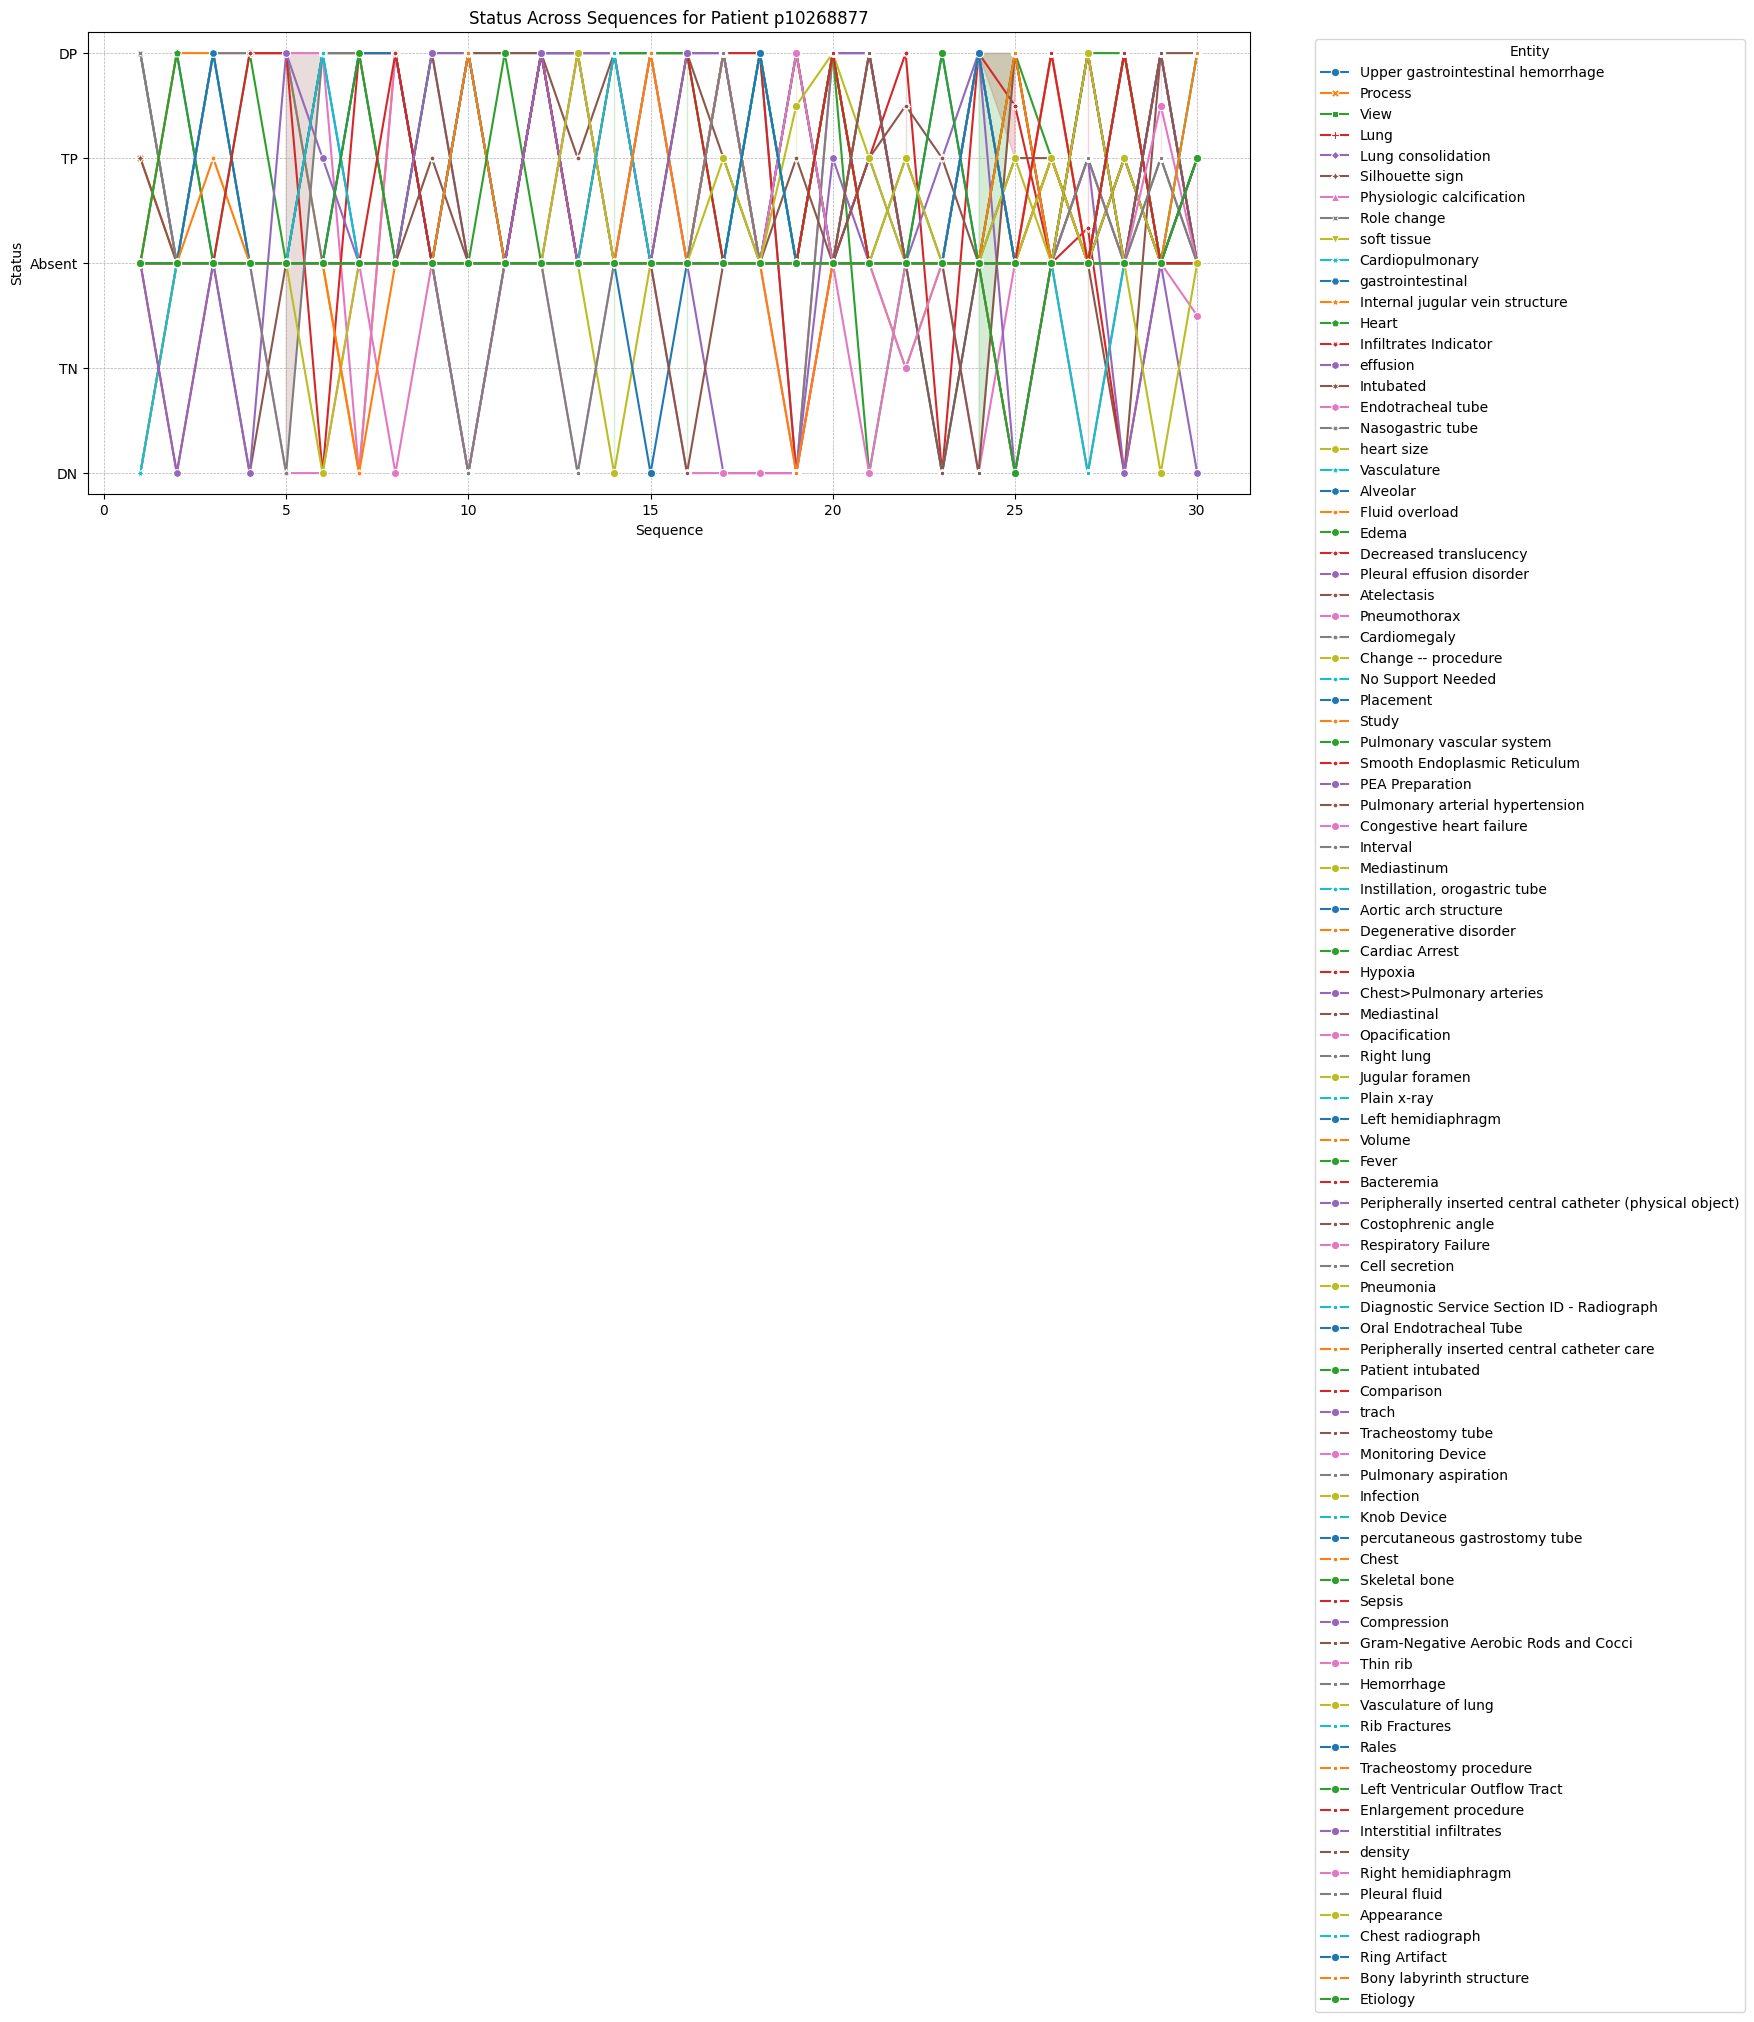

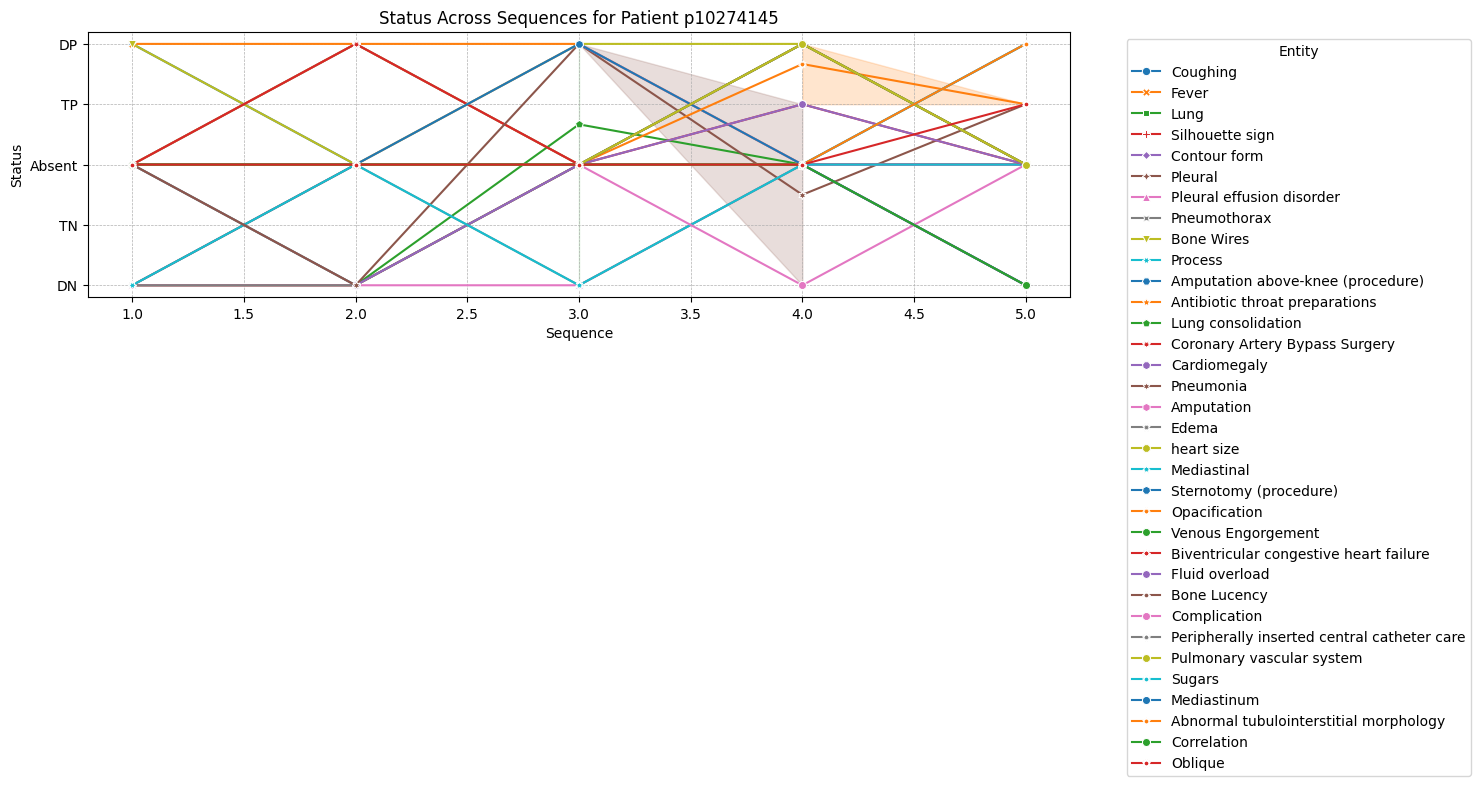

KeyboardInterrupt: 

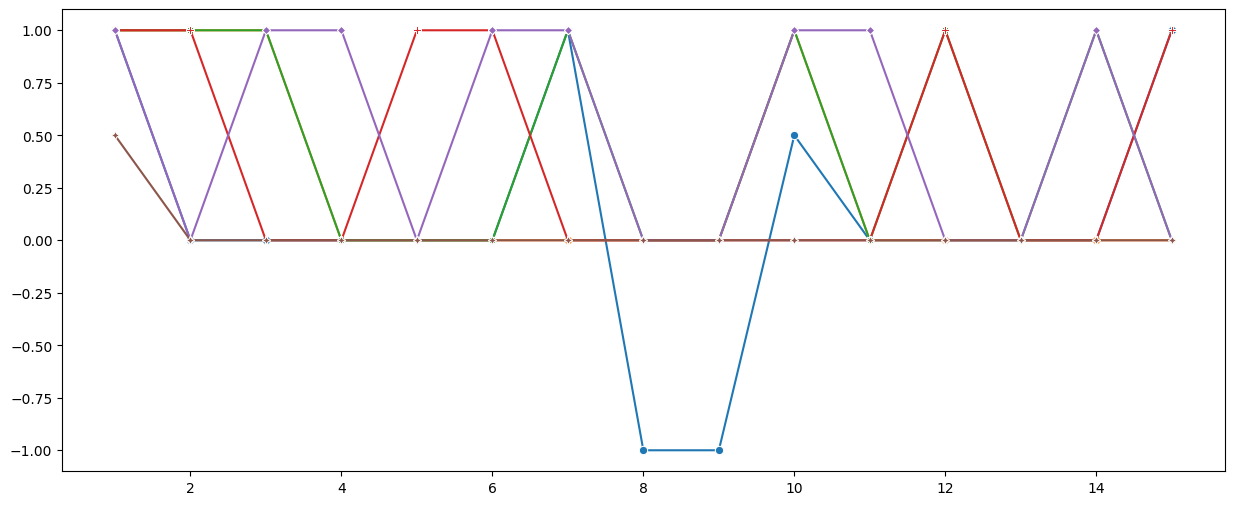

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df_final_filtered' and status_to_numeric_updated mapping are defined as before

# Filter for patients with 5 or more sequences
sequences_per_patient = df_final_filtered.groupby('patient_id')['sequence'].max()
patients_with_5_or_more_sequences = sequences_per_patient[sequences_per_patient >= 5].index

for patient_id in patients_with_5_or_more_sequences:
    patient_data = df_final_filtered[df_final_filtered['patient_id'] == patient_id]
    
    # Initialize an empty DataFrame to store the complete data with all sequences for each spacy_norm
    complete_data = pd.DataFrame()
    
    for spacy_norm in patient_data['spacy_norm'].unique():
        # For each unique spacy_norm, ensure all sequences are represented
        sn_data = patient_data[patient_data['spacy_norm'] == spacy_norm]
        all_sequences = range(1, patient_data['sequence'].max() + 1)  # Assuming sequence starts from 1 and is continuous
        
        # Ensure each sequence is present, fill missing sequences with 'Absent'
        sn_full = pd.DataFrame({'sequence': all_sequences})
        sn_full = sn_full.merge(sn_data[['sequence', 'status_prefix']], on='sequence', how='left').fillna('Absent')
        sn_full['spacy_norm'] = spacy_norm  # Add the spacy_norm column back
        sn_full['NumericStatus'] = sn_full['status_prefix'].map(status_to_numeric_updated)  # Map status to numeric
        
        complete_data = pd.concat([complete_data, sn_full], ignore_index=True)
    
    # Now complete_data contains all sequences for each spacy_norm with 'Absent' filled where applicable
    # Plotting setup using the complete_data for the current patient
    palette = sns.color_palette("tab10", n_colors=complete_data['spacy_norm'].nunique())
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=complete_data, x='sequence', y='NumericStatus', hue='spacy_norm', style='spacy_norm', markers=True, dashes=False, palette=palette)
    
    plt.title(f'Status Across Sequences for Patient {patient_id}')
    plt.xlabel('Sequence')
    plt.ylabel('Status')
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['DN', 'TN', 'Absent', 'TP', 'DP'])
    plt.ylim(-1.1, 1.1)  # Ensure y-axis strictly adheres to the specified values
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [30]:
from collections import defaultdict

def track_sequence_changes_v2(df):
    sequence_changes_v2 = defaultdict(dict)
    
    sorted_df = df.sort_values(by=['patient_id', 'study_id', 'sequence'])
    
    for (patient_id, study_id), group in sorted_df.groupby(['patient_id', 'study_id']):
        prev_cats = None
        prev_entities = None
        
        for sequence, seq_group in group.groupby('sequence'):
            current_cats = set(seq_group['cat'].dropna())
            current_entities = set(seq_group['ent'].dropna())
            
            cat_changes = current_cats.symmetric_difference(prev_cats) if prev_cats is not None else set()
            entity_changes = current_entities.symmetric_difference(prev_entities) if prev_entities is not None else set()

            # 변화가 없는 경우에도 정보를 저장
            sequence_changes_v2[(patient_id, study_id, sequence)] = {
                'current_cats': current_cats,
                'cat_changes': cat_changes if cat_changes else "No changes",
                'current_entities': current_entities,
                'entity_changes': entity_changes if entity_changes else "No changes"
            }
            
            prev_cats = current_cats
            prev_entities = current_entities
    
    return sequence_changes_v2

df_final[['status_prefix', 'status_suffix']] = df_final['status'].str.split('|', expand=True)

# 수정된 함수 실행 및 결과 확인
sequence_changes_v2 = track_sequence_changes_v2(df_final)
list(sequence_changes_v2.items())[:5]  # 결과의 일부만 출력하여 확인



[(('p10032725', 's50331901', 1),
  {'current_cats': {'OTH', 'ROF'},
   'cat_changes': 'No changes',
   'current_entities': {'Intubated',
    'cardiomediastinal silhouettes',
    'endotracheal tube',
    'hilar silhouettes',
    'lungs',
    'pleural surfaces'},
   'entity_changes': 'No changes'}),
 (('p10032725', 's55504914', 2),
  {'current_cats': {'OTH', 'ROF'},
   'cat_changes': 'No changes',
   'current_entities': {'ET tube',
    'adenopathy',
    'heart size',
    'lungs',
    'nasogastric tube'},
   'entity_changes': 'No changes'}),
 (('p10046166', 's50051329', 6),
  {'current_cats': {'OTH', 'ROF', 'SYM'},
   'cat_changes': 'No changes',
   'current_entities': {'acute cardiopulmonary process',
    'airspace consolidation',
    'calcified granuloma',
    'confusion',
    'lungs',
    'metastatic melanoma',
    'motion artifact',
    'pleural effusions',
    'pneumothorax',
    'pulmonary edema',
    'somnolence',
    'sternotomy wire',
    'surgical clips',
    'vascular markers'}

In [33]:
def track_sequence_status_and_changes(df):
    # 결과를 저장할 사전 초기화
    sequence_status_and_changes = defaultdict(dict)
    
    sorted_df = df.sort_values(by=['patient_id', 'study_id', 'sequence'])
    
    for (patient_id, study_id), group in sorted_df.groupby(['patient_id', 'study_id']):
        prev_info = set()  # 이전 시퀀스 정보 저장 변수 초기화
        
        for sequence, seq_group in group.groupby('sequence'):
            # 현재 시퀀스의 'cat'-'entity'-'status' 쌍 추출
            current_info = set(seq_group.apply(lambda x: (x['cat'], x['ent'], x['status_prefix']), axis=1))
            
            # 현재 상태 기록
            sequence_status_and_changes[(patient_id, study_id, sequence)]['current_status'] = current_info
            
            # 첫 번째 시퀀스가 아닌 경우, 이전 시퀀스와의 변화 추적
            if sequence > 1:
                added = current_info - prev_info
                removed = prev_info - current_info
                sequence_status_and_changes[(patient_id, study_id, sequence)]['added'] = added
                sequence_status_and_changes[(patient_id, study_id, sequence)]['removed'] = removed
            
            # 현재 시퀀스 정보를 다음 비교를 위해 이전 시퀀스로 업데이트
            prev_info = current_info
    
    return sequence_status_and_changes

# 함수 실행 및 결과 확인
sequence_status_changes = track_sequence_status_and_changes(df_final)
list(sequence_status_changes.items())[:5]  # 결과의 일부만 출력하여 확인


[(('p10032725', 's50331901', 1),
  {'current_status': {('OTH', 'Intubated', 'DP'),
    ('OTH', 'endotracheal tube', 'DP'),
    ('ROF', 'cardiomediastinal silhouettes', 'DN'),
    ('ROF', 'hilar silhouettes', 'DN'),
    ('ROF', 'lungs', 'DN'),
    ('ROF', 'pleural surfaces', 'DN')}}),
 (('p10032725', 's55504914', 2),
  {'current_status': {('OTH', 'ET tube', 'DP'),
    ('OTH', 'nasogastric tube', 'DP'),
    ('ROF', 'adenopathy', 'DP'),
    ('ROF', 'heart size', 'DN'),
    ('ROF', 'lungs', 'DP')},
   'added': {('OTH', 'ET tube', 'DP'),
    ('OTH', 'nasogastric tube', 'DP'),
    ('ROF', 'adenopathy', 'DP'),
    ('ROF', 'heart size', 'DN'),
    ('ROF', 'lungs', 'DP')},
   'removed': set()}),
 (('p10046166', 's50051329', 6),
  {'current_status': {('OTH', 'metastatic melanoma', 'DP'),
    ('OTH', 'motion artifact', 'DN'),
    ('OTH', 'sternotomy wire', 'DP'),
    ('OTH', 'surgical clips', 'DP'),
    ('OTH', 'vascular markers', 'DP'),
    ('ROF', 'acute cardiopulmonary process', 'DN'),
    ('R

In [14]:
from collections import defaultdict

# Initialize a dictionary to hold the counts of each status code for each entity
entity_status_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each row in the dataset
for _, row in df_final.iterrows():
    entity = row['ent']
    if pd.isna(row['status']):  # Skip rows where status might be NaN
        continue
    statuses = str(row['status']).split('|')[0]  # Split the status by '|' to handle multiple statuses
    entity_status_counts[entity][statuses] += 1  # Increment count

# Convert defaultdict to a regular dict for easier viewing
entity_status_counts_dict = {entity: dict(statuses) for entity, statuses in entity_status_counts.items()}

# Let's preview a portion of this dictionary to check our results
dict(list(entity_status_counts_dict.items())[:10])


{'Intubated': {'DP': 13},
 'endotracheal tube': {'DP': 160, 'DN': 18, 'TP': 14},
 'lungs': {'DN': 290, 'DP': 193, 'TN': 2, 'TP': 1},
 'cardiomediastinal silhouettes': {'DN': 8, 'DP': 1},
 'hilar silhouettes': {'DN': 21},
 'pleural surfaces': {'DN': 24, 'DP': 1},
 'ET tube': {'DP': 137, 'DN': 9, 'TP': 4},
 'nasogastric tube': {'DP': 121, 'DN': 17, 'TP': 6},
 'heart size': {'DN': 272, 'DP': 142, 'TP': 18},
 'adenopathy': {'DP': 6, 'DN': 2}}

In [9]:
# Combining 'TP' with 'TN' and 'DP' with 'DN' as requested
for entity, statuses in entity_status_counts.items():
    # Combine 'TP' with 'TN'
    tp_tn_sum = statuses.get('TP', 0) + statuses.get('TN', 0)
    if tp_tn_sum > 0:
        statuses['tentative'] = tp_tn_sum
        statuses.pop('TP', None)
        statuses.pop('TN', None)
    
    # Combine 'DP' with 'DN'
    dp_dn_sum = statuses.get('DP', 0) + statuses.get('DN', 0)
    if dp_dn_sum > 0:
        statuses['definitive'] = dp_dn_sum
        statuses.pop('DP', None)
        statuses.pop('DN', None)

# Update the dictionary with the combined counts
combined_entity_status_counts_dict = {entity: dict(statuses) for entity, statuses in entity_status_counts.items()}

# Let's preview the updated dictionary with combined counts
dict(list(combined_entity_status_counts_dict.items())[:10])


{'Intubated': {'definitive': 13},
 'endotracheal tube': {'tentative': 14, 'definitive': 178},
 'lungs': {'tentative': 3, 'definitive': 483},
 'cardiomediastinal silhouettes': {'definitive': 9},
 'hilar silhouettes': {'definitive': 21},
 'pleural surfaces': {'definitive': 25},
 'ET tube': {'tentative': 4, 'definitive': 146},
 'nasogastric tube': {'tentative': 6, 'definitive': 138},
 'heart size': {'tentative': 18, 'definitive': 414},
 'adenopathy': {'definitive': 8}}

In [10]:
# Initialize sets to categorize entities
entities_with_definitive_only = set()
entities_with_tentative_only = set()
entities_with_both = set()

# Categorize entities based on the presence of 'definitive' and 'tentative' statuses
for entity, statuses in combined_entity_status_counts_dict.items():
    if 'definitive' in statuses and 'tentative' in statuses:
        entities_with_both.add(entity)
    elif 'definitive' in statuses and 'tentative' not in statuses:
        entities_with_definitive_only.add(entity)
    elif 'tentative' in statuses and 'definitive' not in statuses:
        entities_with_tentative_only.add(entity)

# Convert sets to lists for easier viewing and sorting
entities_with_definitive_only = sorted(list(entities_with_definitive_only))
entities_with_tentative_only = sorted(list(entities_with_tentative_only))
entities_with_both = sorted(list(entities_with_both))

entities_with_definitive_only[:10], entities_with_tentative_only[:10], entities_with_both[:10]


(['2-vessel CABG',
  '3-channel pacer device',
  '40-pack-year smoking',
  '4v CABG',
  'A-fib',
  'A-flutter',
  'AC joint',
  'AC joint dislocation',
  'AC line placement',
  'AF'],
 ['8th rib fracture',
  'AP and lateral chest radiograph',
  'AP window lesion',
  'Acute myocardial infarction',
  'Atelectasis',
  'Bochdalek hernia',
  'Bronchial obstruction',
  'CHF infiltrate',
  'CT chest',
  'CT evaluation'],
 ['AP chest',
  'ARDS',
  'Bibasilar opacities',
  'CHF',
  'CHF exacerbation',
  'CHF findings',
  'CHF with interstitial edema',
  'COPD',
  'CT',
  'CT scanning'])

In [11]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

display(entities_with_tentative_only)
# display(df_final[df_final['ent'] == 'lung collapse'])
display(df_final[df_final['ent'] == 'rounded shape'])


['8th rib fracture',
 'AP and lateral chest radiograph',
 'AP window lesion',
 'Acute myocardial infarction',
 'Atelectasis',
 'Bochdalek hernia',
 'Bronchial obstruction',
 'CHF infiltrate',
 'CT chest',
 'CT evaluation',
 'CT exam',
 'CT examination',
 'CT of the chest',
 'CT of the thorax',
 'CT scan',
 'CTA chest',
 'CVL placement',
 'Chest CT with contrast',
 'Clinical correlation',
 'Coalescent areas',
 'Conventional radiographs',
 'DAH',
 'Dilatation of the trachea',
 'Duff tube placement',
 'EKG lead',
 'Edema',
 'Hydropneumothorax',
 'ICD pacemaker lead tip',
 'ICH',
 'IJ catheter placement',
 'IPF exacerbation',
 'Left PICC',
 'Left retrocardiac opacity',
 'MS change',
 'Nasogastric tube advancement',
 'Nocardia',
 'Nodular opacities',
 'Opacities',
 'PA and lateral',
 'PA and lateral chest exam',
 'PA and lateral imaging',
 'PA and lateral radiograph',
 'PA catheter',
 'PA expiratory films',
 'PA view',
 'PICC line tubing',
 'PICC positioning',
 'PJP',
 'PTX',
 'Placement',


,Unnamed: 0,patient_id,study_id,sequence,sec,report,sent,ent,cat,status,location,evidence,morphology,distribution,size,num,severity,comparision,emerge,no change,improved,worsened,reposition,resolve,past hx,other source,technical limitation,misc,idx
7923,7923,p18828251,s59257021,2,IMPR,The heart size is enlarged similar to prior study. Its rounded shape raises a question of cardiomyopathy and less likely pericardial effusion. Sternotomy wi.,Its rounded shape raises a question of cardiomyopathy and less likely pericardial effusion.,rounded shape,ROF,TP|raises a question,NaN,"heart size, idx2",rounded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [12]:
df_final[['status_prefix', 'status_suffix']] = df_final['status'].str.split('|', expand=True)

# Grouping by 'patient_id' and 'sequence', then aggregating 'ent' and 'status_prefix'
grouped_data = df_final.groupby(['patient_id', 'sequence']).agg({
    'ent': lambda x: list(x),
    'cat': lambda x: list(x),
    'location': lambda x: list(x),
    'evidence': lambda x: list(x),
    'morphology': lambda x: list(x),
    'distribution': lambda x: list(x),
    'size': lambda x: list(x),
    'num': lambda x: list(x),
    'severity': lambda x: list(x),
    'comparision': lambda x: list(x),
    'emerge': lambda x: list(x),
    'no change': lambda x: list(x),
    'improved': lambda x: list(x),
    'worsened': lambda x: list(x),
    'reposition': lambda x: list(x),
    'resolve': lambda x: list(x),
    'past hx': lambda x: list(x),
    'other source': lambda x: list(x),
    'technical limitation': lambda x: list(x),
    'misc': lambda x: list(x),
    'idx': lambda x: list(x),
    'status_prefix': lambda x: list(x)
}).reset_index()

sequence_counts = df_final.groupby('patient_id').sequence.nunique()

# Filtering patients based on the count of sequences
patients_with_1_sequence = sequence_counts[sequence_counts == 1].index.tolist()
patients_with_2_to_10_sequences = sequence_counts[(sequence_counts >= 2) & (sequence_counts <= 10)].index.tolist()
patients_with_more_than_10_sequences = sequence_counts[sequence_counts > 10].index.tolist()

grouped_data_1_sequence = grouped_data[grouped_data['patient_id'].isin(patients_with_1_sequence)]
grouped_data_2_to_10_sequences = grouped_data[grouped_data['patient_id'].isin(patients_with_2_to_10_sequences)]
grouped_data_more_than_10_sequences = grouped_data[grouped_data['patient_id'].isin(patients_with_more_than_10_sequences)]
display(grouped_data_more_than_10_sequences.head(2))

,patient_id,sequence,ent,cat,location,evidence,morphology,distribution,size,num,severity,comparision,emerge,no change,improved,worsened,reposition,resolve,past hx,other source,technical limitation,misc,idx,status_prefix
9,p10268877,1,"[upper GI bleed, intrathoracic process, AP portable view, lungs, confluent consolidation, cardiac silhouette, calcifications, degenerative changes, osseous and soft tissue structures, cardiopulmonary process, cardiac silhouette]","[COF, ROF, OTH, ROF, ROF, ROF, ROF, ROF, ROF, ROF, ROF]","[nan, nan, chest, nan, lungs, nan, aortic arch, glenohumeral joints bilaterally, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, large, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, acute, nan, nan, nan, nan, nan, nan, nan, acute, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no prior, nan, nan, could be accentuated by positioning and relatively low inspiratory effort, nan, nan, nan, nan, patients positioning]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]","[DP, TP, DP, DN, DN, TP, DP, DP, DN, DN, TP]"
10,p10268877,2,"[GI bleed, IJ Cordis, old films, heart, IJ Cordis, pulmonary vascular re-distribution, infiltrates, effusion]","[SYM, OTH, OTH, ROF, OTH, ROF, ROF, ROF]","[nan, right, nan, nan, right, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, moderately, nan, mild, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no available, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, medical device, nan, nan, medical device, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no comparison, enlarged, tip in the upper svc, nan, nan, nan]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]","[DP, DP, DN, DP, DP, DP, DN, DN]"


In [13]:
# # Function to combine non-NaN values across different columns for each entity
# def combine_details(row):
#     combined_details = []
#     entities = row['ent']
#     # Columns to consider for combining details
#     columns = ['cat', 'location', 'evidence', 'morphology', 'distribution', 'size', 'num', 'severity',
#                'comparision', 'emerge', 'no change', 'improved', 'worsened', 'reposition', 'resolve',
#                'past hx', 'other source', 'technical limitation', 'misc', 'status_prefix']
    
#     # Iterate through each entity and combine non-NaN details from other columns
#     for i, entity in enumerate(entities):
#         details = {'entity': entity}
#         for col in columns:
#             try:
#                 # Skip if the value is NaN or if the column does not have a corresponding value for the index
#                 if pd.isna(row[col][i]) or row[col][i] == 'nan':
#                     continue
#                 # Add detail from the column if it exists and is not NaN
#                 details[col] = row[col][i]
#             except IndexError:
#                 # If the index is out of bounds for the column, skip
#                 continue
#         combined_details.append(details)
    
#     return combined_details

# # Applying the function to the grouped data to combine details for each entity
# grouped_data_more_than_10_sequences['combined_details'] = grouped_data_more_than_10_sequences.apply(combine_details, axis=1)

# # Showing the combined details for the first few rows to verify the operation
# grouped_data_more_than_10_sequences['combined_details'].head()

# Updating the function to include combinations without 'entity' but with 'cat', 'status_prefix', and additional attributes
# Updating the function to include the key (attribute name) alongside the value in the combinations

def count_combinations_with_keys(details):
    entity_cat_status = defaultdict(int)
    entity_cat_status_attributes = defaultdict(int)
    cat_status_attributes = defaultdict(int)  # For combinations without 'entity'

    for detail in details:
        entity = detail.get('entity')
        cat = detail.get('cat', '')
        status_prefix = detail.get('status_prefix', '')

        # Including attribute names (keys) with their values
        attributes = ['evidence', 'morphology', 'distribution', 'size', 'num', 'severity',
                      'comparision', 'no change', 'improved', 'worsened', 
                      'reposition', 'resolve', 'past hx', 'other source', 
                      'technical limitation', 'misc']

        # attribute_key_values = [f"{attr}:{detail[attr]}" for attr in attributes if detail.get(attr, '')]
        attribute_key_values = [attr for attr in attributes if detail.get(attr, '')]
        attribute_kv_str = '-'.join(attribute_key_values) if attribute_key_values else ''

        if entity:
            ecs = f"{entity}-{cat}-{status_prefix}"
            entity_cat_status[ecs] += 1

            if attribute_key_values:
                ecsa = f"{entity}-{cat}-{status_prefix}-{attribute_kv_str}"
                entity_cat_status_attributes[ecsa] += 1

        csa = f"{cat}-{status_prefix}-{attribute_kv_str}"
        cat_status_attributes[csa] += 1

    return cat_status_attributes#entity_cat_status, entity_cat_status_attributes, cat_status_attributes

# Re-applying the updated function across the grouped data
grouped_data['counts_with_keys'] = grouped_data['combined_details'].apply(lambda x: count_combinations_with_keys(x))

# Extracting counts that include keys for demonstration
counts_with_keys_examples = grouped_data[['patient_id', 'sequence', 'counts_with_keys']].head()

# Summarizing the updated counts including keys for attributes
patient_sequence_counts_with_keys = defaultdict(lambda: defaultdict(list))

for _, row in grouped_data.iterrows():
    patient_id = row['patient_id']
    sequence = row['sequence']
    cat_status_attributes = row['counts_with_keys']
    # entity_cat_status, entity_cat_status_attributes, cat_status_attributes = row['counts_with_keys']

    # for ecs in entity_cat_status:
    #     patient_sequence_counts_with_keys[patient_id]['entity_cat_status'].append((sequence, ecs, entity_cat_status[ecs]))
    # for ecsa in entity_cat_status_attributes:
    #     patient_sequence_counts_with_keys[patient_id]['entity_cat_status_attributes'].append((sequence, ecsa, entity_cat_status_attributes[ecsa]))
    for csa in cat_status_attributes:
        patient_sequence_counts_with_keys[patient_id]['cat_status_attributes'].append((sequence, csa, cat_status_attributes[csa]))

# Format and show a summary of the findings for the first patient as an example with counts that include keys
first_patient_id_with_keys = next(iter(patient_sequence_counts_with_keys))
summary_example_with_keys = {
    'entity_cat_status': patient_sequence_counts_with_keys[first_patient_id_with_keys]['entity_cat_status'][:5],  # First 5 examples
    'entity_cat_status_attributes': patient_sequence_counts_with_keys[first_patient_id_with_keys]['entity_cat_status_attributes'][:5],  # First 5 examples
    'cat_status_attributes': patient_sequence_counts_with_keys[first_patient_id_with_keys]['cat_status_attributes'][:5]  # First 5 examples if any
}
counts_with_keys_examples, summary_example_with_keys
display(counts_with_keys_examples)#, display(summary_example_final)


KeyError: 'combined_details'

In [ ]:
grouped_data_more_than_10_sequences.head()

,patient_id,sequence,ent,cat,location,evidence,morphology,distribution,size,num,severity,comparision,emerge,no change,improved,worsened,reposition,resolve,past hx,other source,technical limitation,misc,idx,status_prefix,combined_details
9,p10268877,1,"[upper GI bleed, intrathoracic process, AP portable view, lungs, confluent consolidation, cardiac silhouette, calcifications, degenerative changes, osseous and soft tissue structures, cardiopulmonary process, cardiac silhouette]","[COF, ROF, OTH, ROF, ROF, ROF, ROF, ROF, ROF, ROF, ROF]","[nan, nan, chest, nan, lungs, nan, aortic arch, glenohumeral joints bilaterally, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, large, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, acute, nan, nan, nan, nan, nan, nan, nan, acute, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no prior, nan, nan, could be accentuated by positioning and relatively low inspiratory effort, nan, nan, nan, nan, patients positioning]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]","[DP, TP, DP, DN, DN, TP, DP, DP, DN, DN, TP]","[{'entity': 'upper GI bleed', 'cat': 'COF', 'status_prefix': 'DP'}, {'entity': 'intrathoracic process', 'cat': 'ROF', 'emerge': 'acute', 'status_prefix': 'TP'}, {'entity': 'AP portable view', 'cat': 'OTH', 'location': 'chest', 'technical limitation': 'no prior', 'status_prefix': 'DP'}, {'entity': 'lungs', 'cat': 'ROF', 'status_prefix': 'DN'}, {'entity': 'confluent consolidation', 'cat': 'ROF', 'location': 'lungs', 'size': 'large', 'status_prefix': 'DN'}, {'entity': 'cardiac silhouette', 'cat': 'ROF', 'technical limitation': 'could be accentuated by positioning and relatively low inspiratory effort', 'status_prefix': 'TP'}, {'entity': 'calcifications', 'cat': 'ROF', 'location': 'aortic arch', 'status_prefix': 'DP'}, {'entity': 'degenerative changes', 'cat': 'ROF', 'location': 'glenohumeral joints bilaterally', 'status_prefix': 'DP'}, {'entity': 'osseous and soft tissue structures', 'cat': 'ROF', 'status_prefix': 'DN'}, {'entity': 'cardiopulmonary process', 'cat': 'ROF', 'emerge': 'acute', 'status_prefix': 'DN'}, {'entity': 'cardiac silhouette', 'cat': 'ROF', 'technical limitation': 'patients positioning', 'status_prefix': 'TP'}]"
10,p10268877,2,"[GI bleed, IJ Cordis, old films, heart, IJ Cordis, pulmonary vascular re-distribution, infiltrates, effusion]","[SYM, OTH, OTH, ROF, OTH, ROF, ROF, ROF]","[nan, right, nan, nan, right, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, moderately, nan, mild, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no available, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, medical device, nan, nan, medical device, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, no comparison, enlarged, tip in the upper svc, nan, nan, nan]","[0.0

# Annotation set?

## 3천개 중에 대략 1천개 sampling. 현실적으로, 인당 300개 1 week면 가능. Candidate
### 1k 어떻게?
### 각 스터디에서 entity-status-location-attribute-other info 분포 확인.


### 전체 데이터셋 분석 먼저 때리기.
    - 전체 entity는 어떻게 분포하는지?
    - 전체 status는 어떻게 분포하는지?
        - Definitive/tentative한 경우 어떤 category에 대해 다르게 분포하는지?
    - attribute의 category는 어떻게 분포하는지?
        - technical issue는 몇%, 뭐는 x%, morphology에 대한 논의는 xx% 등
        => attribute가 최대한 많이 있는 샘플들을 골라야함. (질문 다양하게 하기 위해)
        만약, attribute가 아예 없는 것들은 또 어떤것들인지 조사해보기

    -> 가장 좋은 set은 한번도 중복이 없는 다양한 셋들.
    => 동일 entity에 대해서도 status, attribute 등이 다르면 좋음.


### Entity 분석: 
    1. major finding이 
        RSF,ROF인 경우
        OTH인 경우


### Status 분석: 
    (90%?) 1. progess change (sequence 변화에 따라 질병이 변화는 경우)
        동일 entity의 status가 sequence가 변함에따라 변화가 있던 케이스들.
        - DP -> DN, dn -> dp, tp -> dp
            ex. (seq 1) find A - TP (seq N) find A - DP/DN

        이런 변화가 있을 경우, 무엇때문에 진단 상태에 따른 변화가 있었을지?
        => attribute 분석. 
            ex. CT 결과때문에? 

    (10%?) 2. progess no change (sequence 변화에 따라 질병이 변화는 경우)
        동일 entity의 status가 sequence가 변함에따라 변화가 있던 케이스들.
                ex. (seq 1) find A - TP (seq N) find A - DP/DN

    - 상황별 분포에 대한 측정은 실제 데이터에 얼만큼 있는지를 먼저 파악하고, 이에 기반해 동일 ratio로 가자.

1. 

# 1. unique entity set

## Normalize 
    - Synonym 처리 (abbreviation, paraphrase)
    - Location (29 body part)
    - 
    - Label hierachy 
        - Device, Disease, Anatomy

## 

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

# # Filter data for the selected patient
patient_id = 'p10268877'
patient_data = df_final[df_final['patient_id'] == patient_id]

# # Create a network graph
# G = nx.Graph()

# # Tracking entity-status pairs across sequences
# sequences = patient_data['sequence'].unique()
# for seq in sequences:
#     seq_data = patient_data[patient_data['sequence'] == seq]
#     unique_pairs = seq_data.apply(lambda x: f"{x['ent']} ({x['status_prefix']})", axis=1).unique()
    
#     # Add nodes and edges for the first sequence
#     if seq == sequences[0]:
#         for pair in unique_pairs:
#             G.add_node(pair, sequence=seq)
#     else:
#         # Add edges from nodes in the first sequence to new occurrences in this sequence
#         prev_seq_pairs = set(G.nodes)
#         for pair in unique_pairs:
#             if pair in prev_seq_pairs:
#                 # If the pair exists, link it to its previous occurrence
#                 G.add_edge(list(G.nodes)[-1], pair, sequence=seq)
#             else:
#                 # If it's a new pair, add a new node
#                 G.add_node(pair, sequence=seq)
#                 # Connect this new node to a 'blank' node to indicate absence in previous sequences
#                 blank_node = f"Blank-{seq}"
#                 G.add_node(blank_node, sequence=seq-1)
#                 G.add_edge(blank_node, pair, sequence=seq)

# # Drawing the graph
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)  # for consistent layout
# nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
# plt.title(f"Entity-Status Network for Patient {patient_id}")
# plt.show()

# Filter data for the specified patient 'p10268877'
df_patient = df_final[df_final['patient_id'] == 'p10268877']

# Creating a list of unique entity-status pairs for each sequence
df_patient['entity_status'] = df_patient['ent'] + '-' + df_patient['status'].str.split('|').str[0]

# Sorting by sequence to ensure order
df_patient_sorted = df_patient.sort_values(by=['sequence'])

# Get unique sequences
sequences = df_patient_sorted['sequence'].unique()

# Initialize a graph
G = nx.DiGraph()

# Tracking nodes to maintain order and connections
prev_nodes = []
for seq in sequences:
    current_nodes = df_patient_sorted[df_patient_sorted['sequence'] == seq]#['entity_status'].unique()
    unique_pairs = current_nodes.apply(lambda x: f"{x['ent']} ({x['status_prefix']})", axis=1).unique()
    # Add current sequence nodes
    for node in unique_pairs:
        if node not in G:
            G.add_node(node, sequence=seq)
    # Connect previous sequence nodes to current, if there are any
    if prev_nodes:
        for p_node in prev_nodes:
            for c_node in unique_pairs:
                if p_node == c_node:
                    G.add_edge(p_node, c_node)
                    break
            else:  # If no match in current nodes, connect to a blank node indicating absence
                blank_node = f"Blank-{seq}"
                G.add_node(blank_node, sequence=seq)
                G.add_edge(p_node, blank_node)
    # Update previous nodes list
    prev_nodes = unique_pairs

# Drawing the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=9, edge_color="gray", width=2)
plt.title(f"Entity-Status Transition for Patient p10268877")
plt.axis('off')
plt.show()


/tmp/ipykernel_1930810/1215681913.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['entity_status'] = df_patient['ent'] + '-' + df_patient['status'].str.split('|').str[0]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()